In [1]:
from exmoset import MolSpace
from exmoset.fingerprints import fingerprints, Fingerprint
from rdkit import Chem
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 

def set_numpy_decimal_places(places, width=0):
    set_np = '{0:' + str(width) + '.' + str(places) + 'f}'
    np.set_printoptions(formatter={'float': lambda x: set_np.format(x)})
    
set_numpy_decimal_places(3)

def bond_converter(smiles):
    return [b.GetBondType().__str__() for b in Chem.MolFromSmiles(smiles).GetBonds()]

space = MolSpace(fingerprints=fingerprints,
                      file="paper/Latent/Embedded_Gap_Mols.csv",
                      mol_converters={"rd" : Chem.MolFromSmiles, "smiles" : str, "bonds" : bond_converter},
                      index_col="SMILES",
                      clusters={})


  1%|          | 1272/133885 [00:00<00:10, 12715.22it/s]

Importing paper/Latent/Embedded_Gap_Mols.csv
Converting Molecules


100%|██████████| 133885/133885 [00:14<00:00, 9512.34it/s] 
/home/adam/PhD/exmoset/exmoset/molspace.py:109: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.mol_iters = {mol_type : np.array([mol[mol_type] for mol in self.Molecules]) for mol_type in self.Molecules[0].types}
  0%|          | 0/15 [00:00<?, ?it/s]

Calculating Properties


100%|██████████| 15/15 [00:02<00:00,  5.71it/s]

Generating Clusters


In [ ]:
extra_df = pd.read_csv("paper/Latent/QM9_Embedded_DBSCAN.csv")
extra_df["Dipole Moment"]

dip_data = extra_df[["SMILES","Dipole Moment"]]
dip_data = dip_data.set_index("SMILES")
def get_dipole(smile):
    return float(dip_data.loc[smile])

a = Fingerprint(property=f"Dipole Moment",
                verb="has a",
                noun="Molecules",
                label_type="continuous",
                calculator=get_dipole,
                mol_format="smiles")

space.add_fingerprint(a)

space.add_cluster(["hidi",np.array(space.data["Dipole Moment"] > 10)])
space["hidi"]

In [2]:
#dbscan_labels = pd.read_csv("paper/Latent/QM9_Embedded_DBSCAN.csv")["DBSCAN"]
base_labels = pd.read_csv("paper/Latent/Untrained_Clusters.csv")["DBSCAN"]
isotropic_labels = pd.read_csv("paper/Latent/Isotropic_Clusters.csv")["DBSCAN"]
dipole_labels = pd.read_csv("paper/Latent/Dipole_Clusters.csv")["DBSCAN"]
gap_labels = pd.read_csv("paper/Latent/Gap_Clusters.csv")["DBSCAN"]

In [3]:
space.add_cluster(["untrained",base_labels])
space.add_cluster(["isotropic",isotropic_labels])
space.add_cluster(["dipole",dipole_labels])
space.add_cluster(["gap",gap_labels])

In [6]:
space.gen_labels("untrained")

['Molecules contain Rings less than 3\nMolecules do not contain triple bonds\nMutual Information 0.08031068379809665',
 'Molecules contain 0 Rings\nMolecules contain double bonds\nMolecules do not contain triple bonds\nMutual Information 0.1996192827124537',
 'Molecules contain 0 Rings\nMolecules contain double bonds\nMolecules contain triple bonds\nMutual Information 0.18740182041433118',
 'Molecules contain 1 Rings\nMolecules do not contain N\nMutual Information 0.01294959017898746',
 'Molecules contain 0 Rings\nMolecules do not contain double bonds\nMolecules contain triple bonds\nMutual Information 0.024989098442130552',
 'Molecules are not Aromatic\nMolecules contain 1 Rings\nMolecules do not contain double bonds\nMolecules do not contain triple bonds\nMutual Information 0.08661089033718013',
 'Molecules are not Aromatic\nMolecules contain 1 Rings\nMolecules contain double bonds\nMolecules do not contain triple bonds\nMutual Information 0.4563176858671362',
 'Molecules contain 1 R

In [134]:
def aromatic_2ring(mol):
    return 1 if (mol.GetRingInfo().NumRings() == 2 and bool(mol.GetAromaticAtoms())) else 0
    
aromatic_2r = Fingerprint(property=f"2 Rings Aromatic",
                verb="contain",
                noun="Molecules",
                label_type="binary",
                calculator=aromatic_2ring,
                mol_format="rd")


In [5]:
match = Chem.MolFromSmarts("[#6;H0;X4]") # Carbon Connected to zero hydrogens and has four connections (14)
def has_quat(mol):
    return int(mol.HasSubstructMatch(match))

a = Fingerprint(property=f"Quatenary Carbon",
                verb="has a",
                noun="Molecules",
                label_type="binary",
                calculator=has_quat,
                mol_format="rd")

space.add_fingerprint(a)

a.summary(1,entropy=0.)

'Molecules has a Quatenary Carbon'

In [11]:
a.summary(0,entropy=0)

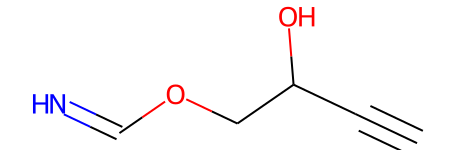

In [37]:
num  = 690
dat = 1
m = space.mol_iters['rd'][space["dipole"][dat]][num]
space.mol_iters['rd'][space["dipole"][dat]][num]

In [41]:
# Differe labels that I need to be able to generate and the clusters that it will be needed for.
# Need a SMARTS for double bond in a ring (8)
# Need one for fused rings (9)
# Nitrogens in rings (possibly aromatic) (10)
# Carbon connected to four non-hydrogen substitutuents (11)
# Fused rings with oxygen (12) and maybe 13 too
# Nitrogen in (fused) aliphatic ring (14)
# Oxygen in fused aliphatic ring (15)
# Nitrogen and oxygen in strained rings (16)
# Oxygen and Nitrogens in fused rings with double bonds within them (17)
# Branched aliphatic structure with heteroatom substitution (18)
# Four membered rings with ether linkage (19)
# Three fused rings with heteroatoms (20)
# Not sure (21)
# Seems to be larger rings with double bonds (22)
# Two double bonds (23)
# Three fused rings (24)
# Heteroatom substituted isopropyl group (25)
# Four rings (26)
# Fused rings with oxygens and no nitrogens (27)
# Unclustered might contain fluorines?

# Steps

- Write a section that can determine the optimal cutoff point for continuous distributions
    - Check with the entropy, if the entropy value is low then use that label explicitly, but if the entropy is high, then you need to invoke a decision boundary.
    - For discrete multilabels, just enumerate all options (can possibly set a cutoff if I need to) and use the one with the maximum entropy
    - Simulated annealing system is used from scipy optimize - it's quite expensive, so should be used sparingly.
    - The fingerprint methods need to have composite label functionality added. Overload the boolean relations.
    - I think that if a multi or continuous label is used to combine, then it should be converted into a binary label.
    - I now need to write a system that can convert a continuous label into a binary one
    - I should store the bounds to expedite the  calculations for both simulated annealing and multiclass labels
- Write a composite label fingerprint that can be used to compress multiple fingerprints into a single one
# All chemprop tests done with Version 1.3.0

In [66]:
from scipy.optimize import dual_annealing
from functools import reduce
from itertools import combinations

def cost_generator(space,set_,prop,set_val):
    return np.vectorize(lambda x: -space.mi(set_, prop, set_val=set_val, labels=np.array(space.data[prop] >= float(x))))

set_ = "isotropic"
summaries = []
for set_val in range(3):#space[set_].keys():
    fingerprints = []
    binary_labels = []
    mis = np.zeros((1,len(space.fingerprints)))
    ents = np.zeros((1,len(space.fingerprints)))
    for i in range(1):
        idxs = space[set_][set_val]
        for j,fp in enumerate(space.fingerprints.values()):
            mis[i,j] = space.mi(set_,fp.property,set_val=set_val)
            ents[i,j] = space.entropy(idxs,fp.property)
            labels = space.data[fp.property].loc[idxs]
            bounds = (np.min(labels),np.max(labels))
            mi = space.mi(set_,fp.property,set_val=set_val)
            ent = space.entropy(idxs,fp.property)

            if mi > 0.005:
                if ent < (fp.sensitivity):
                    if fp.label_type == "continuous":
                        u = np.mean(labels)
                        var = np.variance(labels)
                        binary_labels.append(((u - 0.1*var) < space.data[fp.property] < (u + 0.1*var)).to_numpy())
                    else:
                        binary_labels.append((space.data[fp.property] == round(np.mean(labels))).to_numpy())
                        fingerprints.append(fp.summary(round(np.mean(labels)),ent,fp.sensitivity+0.1))
                else:
                    if fp.label_type == "binary":
                        binary_labels.append((space.data[fp.property] == round(np.mean(labels))).to_numpy())
                        fingerprints.append(fp.summary(np.mean(labels),ent,sensitivity=1))
                        continue

                    elif fp.label_type == "continuous":
                        split = float(dual_annealing(cost_generator(space,set_,fp.property,set_val=set_val),bounds=np.array([*bounds]),maxiter=250)["x"])
                    else:
                        iterable = np.array(range(*bounds))
                        split = iterable[np.argmin(np.apply_along_axis(cost_generator(space,set_,fp.property,set_val=set_val), 0, iterable))]

                    if split > np.mean(space.data.loc[idxs][fp.property]):
                        fingerprints.append(fp.to_binary(split,"<"))
                        binary_labels.append((space.data[fp.property] < split).to_numpy())
                    else:
                        fingerprints.append(fp.to_binary(split,">"))
                        binary_labels.append((space.data[fp.property] >= split).to_numpy())

    if len(binary_labels) > 1:
        num_options = len(binary_labels)
        binary_labels = np.array(binary_labels)
        
        idxs = []
        for i in range(1,num_options+1):
            idxs.append(list(combinations(list(range(num_options)),i))) # Generate all possible permutations
        idxs = [item for sublist in idxs for item in sublist] # Flatten the list of lists
        mut_infs = []
        for idx in idxs: # Iterate over possible label combinations
            current_label = reduce(np.logical_and, binary_labels[tuple([idx])])
            mut_infs.append(space.mi(set_,"Rings",set_val=set_val,labels=current_label))
            
        summary = [fingerprints[x] for x in idxs[np.argmax(mi_vals)]] # Isolate the fingerprint summaries for each index is the argmax collection
        summaries.append("\n".join(summary) + (f"\nMutual Information {np.max(mi_vals)}"))
        
    elif len(binary_labels) == 1:
        summaries.append("".join(fingerprints))
        
    else:
        summaries.append("No Meaningful Label")
        
print(summaries)

['Molecules contain 0 Rings\nMutual Information 0.48223939738504784', 'Molecules contain double bonds\nMutual Information 0.48223939738504784', 'Molecules contain Rings greater than 2\nMutual Information 0.48223939738504784']


In [ ]:
def combinatorial_optimizer(num_options,labels,cost_function):
    idxs = []
    for i in range(1,num_options+1):
        idxs.append(list(combinations(list(range(num_options)),i))) # Generate all possible permutations
    idxs = [item for sublist in idxs for item in sublist] # Flatten the list of lists
    mut_infs = []
    for idx in idxs: # Iterate over possible label combinations
        current_labels = reduce(np.logical_and, labels[tuple([idx])])
    return idxs

combinatorial_optimizer(5,binary_labels,space.mi)

# Forming a binary label from a multiclass or continuous label

In many cases continuous and multiclass labels can meaningfully distinguish a particular set, while having a very high entropy. This occurs when the label occurs at a boundary, for example as a separation of molecules with 4 or more rings from molecules with 4 or fewer rings. Generating meaningful labels from this requires converting the series label into a binary one by invoking a decision boundary. This process, which is commonly used in decision trees to identify optimal splits, involves determining the point of separation that leads to the greatest possible mutual information. In the case of multiclass labels, this is done by iterating over the possible splits and calculating the mutual information, while for continuous labels, simulated annealing is used with mutual information as the cost function to approximate the globally optimal solution. 

- In the actual paper it might be nice to have an image here explaining how this works.

# Composite Labels

Composite labels are formed from primitive labels through a boolean aggregation procedure. This boolean aggregation procedure requires that the labels adopt a binary formulation, which means that for multiclass labels, almost all labels adopt the same value, whereas for continuous labels, it means that the values lie within a certain tolerance from the mean (arbitrarily set to 0.1 * variance). Composite labels can then be formed through boolean aggregation using the logical and operation. Determining the optimal label is not a trivial problem, and is first achieved by removing all primitive labels with a mutual information below a threshold, then an enumerative optimisation procedure is employed which calculates the label combination that produces the maximum mutual information. This is selected as the final label for the cluster, and a text description is then generated.


In [ ]:
# Sort the array
# Remove entries below a threshold value 
# Then do permutation based optimisation

In [552]:
np.argsort(mis)[:,::-1]

array([[ 2,  8, 13,  0,  5, 10,  6,  7, 14,  1,  4,  9, 12, 11,  3]])

In [ ]:
# The best way to build more effective labels is to sort them, then increase more elements for as long as it increases the mutual information. 
# Then only accept a final label if it exceeds some particular threshold.

In [410]:
space.mi("gap","Aromatic",set_val=2)

0.4298746925160768

In [409]:
space.mi("gap","Rings",set_val=2)

0.20325473549068065

In [ ]:
# Do I want to re-engineer the code so that generating a label meaning recursively adding more label information if it significantly increases its performance?

In [324]:
space.data[fingerprints[1].property]> 2

0         False
1         False
2         False
3         False
4         False
          ...  
133880     True
133881     True
133882     True
133883     True
133884     True
Name: Rings, Length: 133885, dtype: bool

In [328]:
labels = ((space.data[fingerprints[0].property] == 0) & (space.data[fingerprints[1].property] >= 2))

space.mi("gap","Aromatic",set_val=3,labels=labels)

0.22914109366067031

In [123]:
set_ = "gap"
mis = np.zeros((len(space[set_]),len(space.fingerprints)))
ents = np.zeros((len(space[set_]),len(space.fingerprints)))

for i,set_val in enumerate(space[set_].keys()):
    for j, fp in enumerate(space.fingerprints.values()):
        idxs = space[set_][set_val]
        mis[i,j] = space.mi(set_,fp.property,set_val=set_val)
        ents[i,j] = space.entropy(idxs,fp.property)

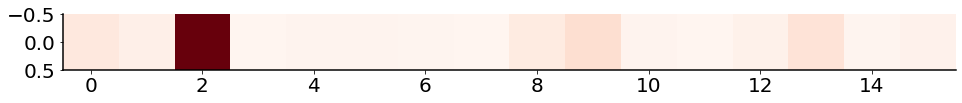

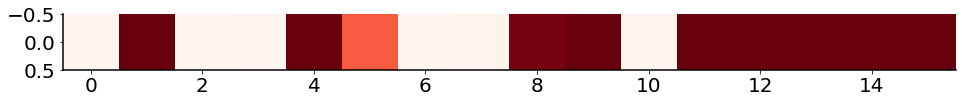

In [165]:
set_val = 1

plt.imshow(mis[set_val].reshape(1,-1),cmap="Reds",vmin=0)
plt.show()
plt.imshow(ents[set_val].reshape(1,-1),cmap="Reds",vmax=0.5)

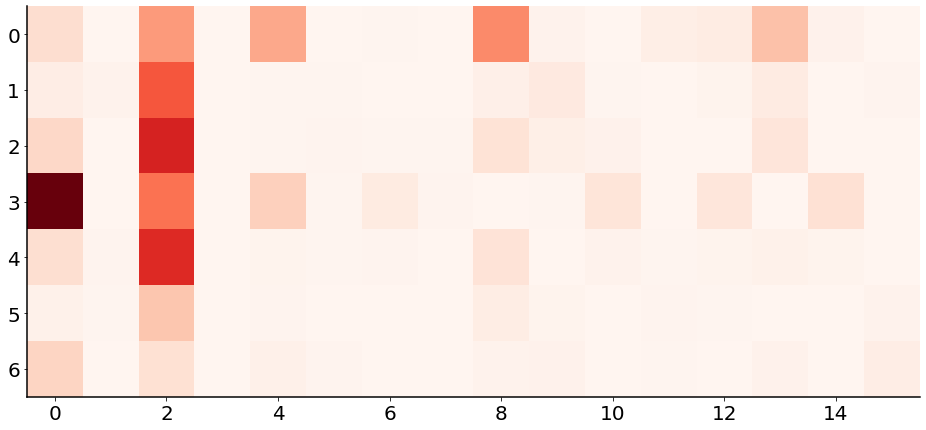

In [176]:
plt.imshow(mis,cmap="Reds",vmin=0)
plt.show()

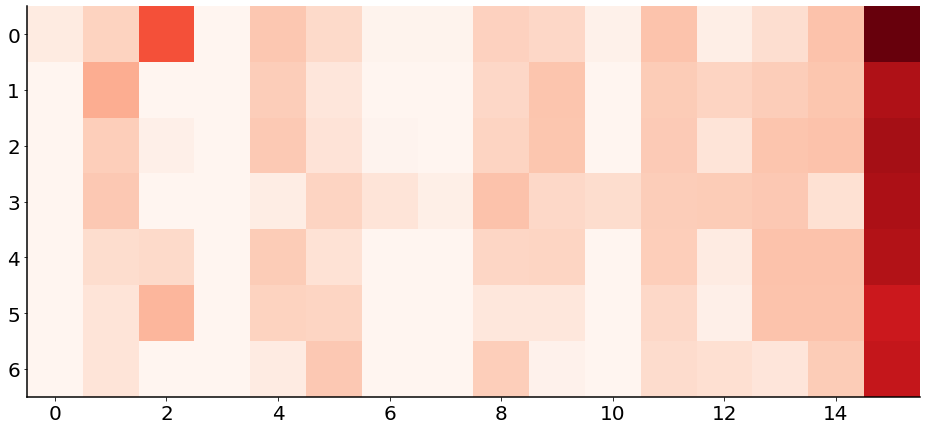

In [161]:
plt.imshow(ents,cmap="Reds",vmin=0)
plt.show()

In [172]:
space.fingerprints

{'Aromatic': Fingerprint(Aromatic,are,Molecules,binary,<function aromatic at 0x7fc805eee290>,rd,0.1),
 'Atoms': Fingerprint(Atoms,contain,Molecules,multiclass,<function num_atoms at 0x7fc805ee9e60>,rd,0.1),
 'Rings': Fingerprint(Rings,contain,Molecules,multiclass,<function num_rings at 0x7fc805f01dd0>,rd,0.1),
 'C': Fingerprint(C,contain,Molecules,binary,<function contains.<locals>.sub_contains at 0x7fc805f01e60>,smiles,0.1),
 'N': Fingerprint(N,contain,Molecules,binary,<function contains.<locals>.sub_contains at 0x7fc805f06200>,smiles,0.1),
 'O': Fingerprint(O,contain,Molecules,binary,<function contains.<locals>.sub_contains at 0x7fc805f06290>,smiles,0.1),
 'F': Fingerprint(F,contain,Molecules,binary,<function contains.<locals>.sub_contains at 0x7fc805f06320>,smiles,0.1),
 'single bonds': Fingerprint(single bonds,contain,Molecules,binary,<function contains.<locals>.sub_contains at 0x7fc805f06170>,bonds,0.1),
 'double bonds': Fingerprint(double bonds,contain,Molecules,binary,<function 

In [ ]:
reduce(&&,labels)

In [65]:
c = cost_generator(space,"gap","Rings",set_val=4)

In [70]:
import cProfile

bounds = (0,9)
iterable = np.array(range(*bounds))
iterable[np.argmin(np.apply_along_axis(c, 0, iterable))]



3

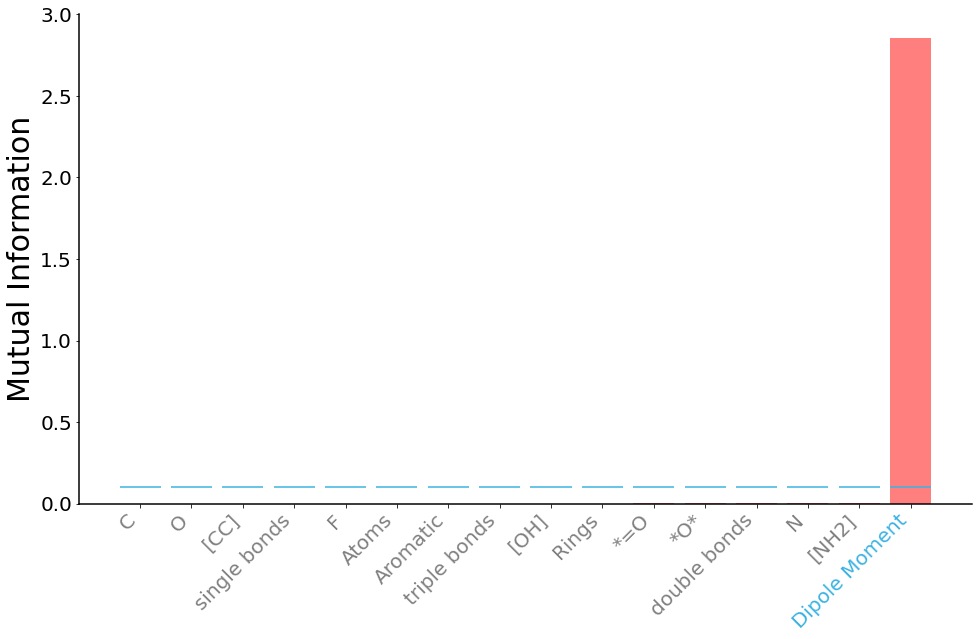

In [39]:
space.plot_mi("hidi",set_val=0)
plt.show()

In [41]:
from scipy.optimize import dual_annealing

dual_annealing(cost_generator(space,"hidi","Dipole Moment",set_val=0),bounds=np.array([[0,40]]),maxiter=250)

     fun: -0.35817600744600153
 message: ['Maximum number of iteration reached']
    nfev: 515
    nhev: 0
     nit: 250
    njev: 7
  status: 0
 success: True
       x: array([4.98657419])

2.4527470978108052

In [119]:
a = Fingerprint(property=f"Dipole Moment",
                verb="has a",
                noun="Molecules",
                label_type="continuous",
                calculator=get_dipole,
                mol_format="smiles")

set_val = 0
x = float(dual_annealing(cost_generator(space,"hidi","Dipole Moment",set_val=set_val),bounds=np.array([[0,40]]),maxiter=250)["x"])
a.to_binary(x,"<" if x > np.mean(space.data.loc[space["hidi"][set_val]]["Dipole Moment"]) else ">")

'Molecules have a Dipole Moment less than 5.024282342677893'

In [34]:
import cProfile

#cProfile.run('-space.mi("hidi","Dipole Moment",set_val=0,labels=np.array(space.data["Dipole Moment"] > float(5)))')

In [ ]:
x = []
for i in np.arange(0,30,0.5):
    x.append(space.mi("hidi","Dipole Moment",set_val=0,labels=np.array(space.data["Dipole Moment"] > i)))
plt.plot(x)
plt.show()

In [27]:
def cost(x):
    return -space.mi("hidi","Dipole Moment",set_val=0,labels=np.array(space.data["Dipole Moment"] > float(x)))

In [7]:
def cost_generator(self,set_,prop_,set_val,labels):
    return lambda x: -space.mi(set_, prop, set_val=set_val, labels=np.array(self.data[prop] > float(x)))

<function __main__.cost_generator.<locals>.<lambda>(x)>

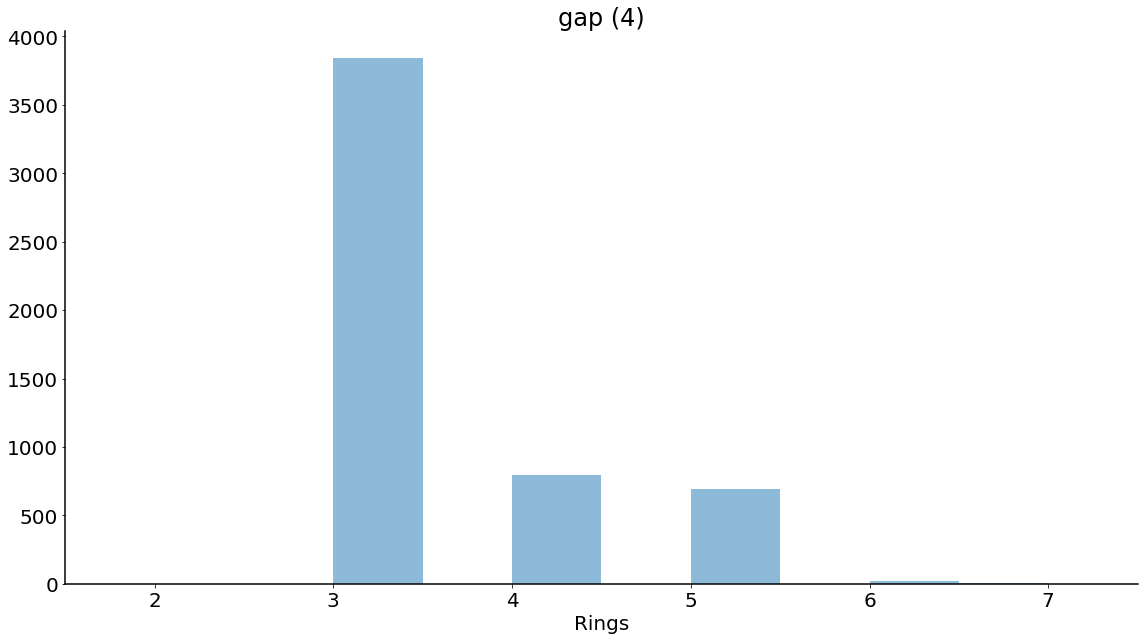

In [46]:
space.plot("gap","Rings",set_val=4)
plt.show()

<AxesSubplot:ylabel='Mutual Information'>

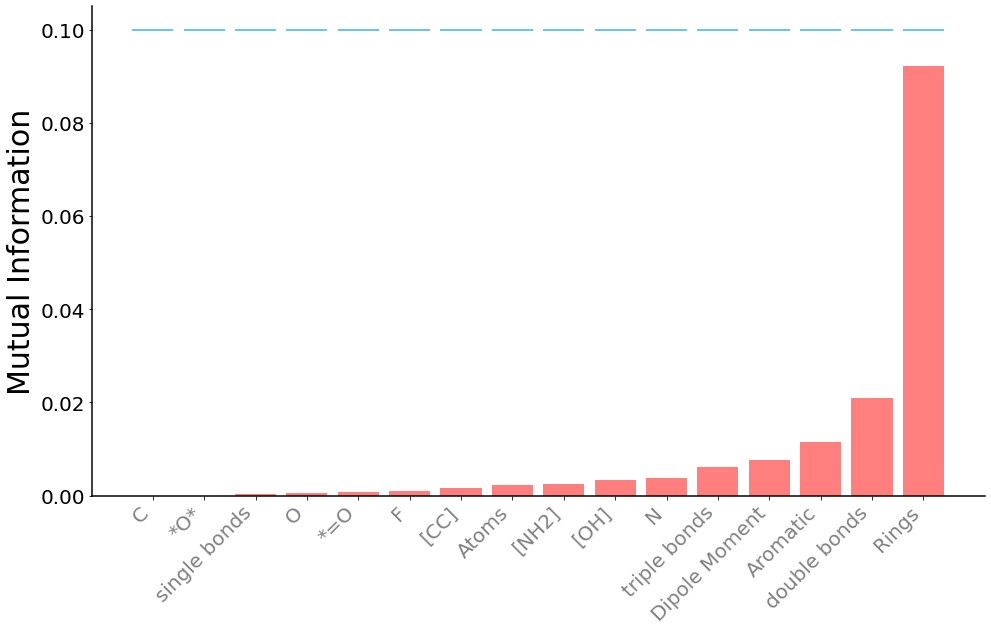

In [42]:
space.plot_mi("gap",set_val=4)

In [72]:
space.mi("isotropic","Rings",set_val=1)

0.37225677204290547

<AxesSubplot:ylabel='Mutual Information'>

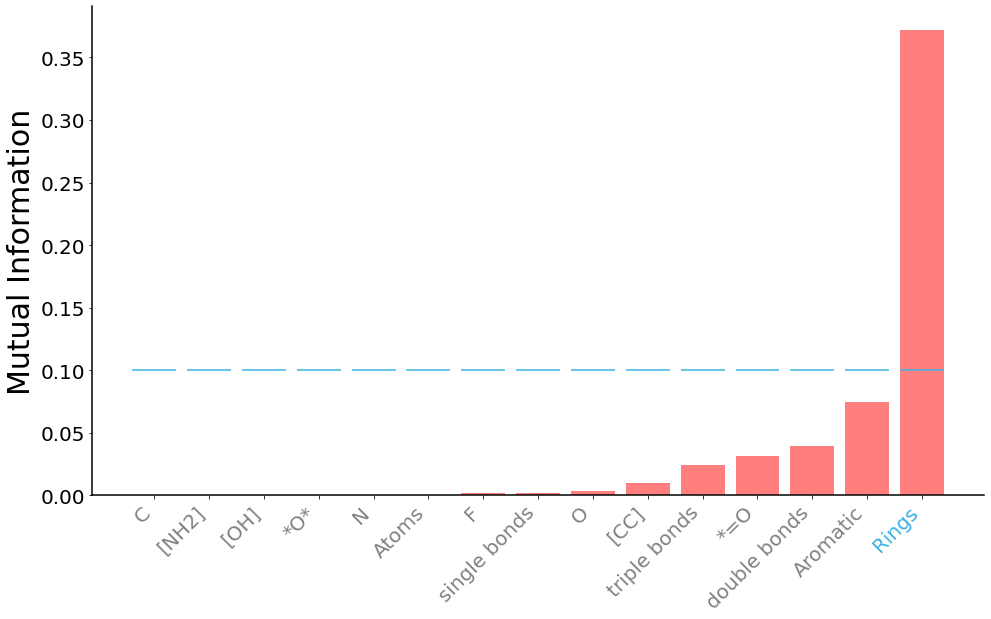

In [73]:
space.plot_mi("isotropic",set_val=1)

In [44]:
space["isotropic"]

{-1: array([    15,     16,     42, ..., 133882, 133883, 133884]),
 0: array([     0,      1,      2, ..., 123266, 123267, 123268]),
 1: array([    44,     88,     89, ..., 133777, 133778, 133779]),
 2: array([    49,     50,     51, ..., 133478, 133479, 133480]),
 3: array([   318,    478,    479, ..., 133590, 133591, 133592]),
 4: array([   317,    319,    641, ..., 133847, 133852, 133860])}

In [45]:
space["gap"]

{-1: array([    15,     16,     20, ..., 133882, 133883, 133884]),
 0: array([     0,      1,      2, ..., 123266, 123267, 123268]),
 1: array([    44,     88,     89, ..., 133777, 133778, 133779]),
 2: array([    49,     50,     51, ..., 133453, 133454, 133455]),
 3: array([   163,    317,    319, ..., 133566, 133568, 133588]),
 4: array([   680,    681,    697, ..., 133841, 133847, 133852]),
 5: array([  1078,   1079,   1080, ..., 131773, 131774, 131775])}

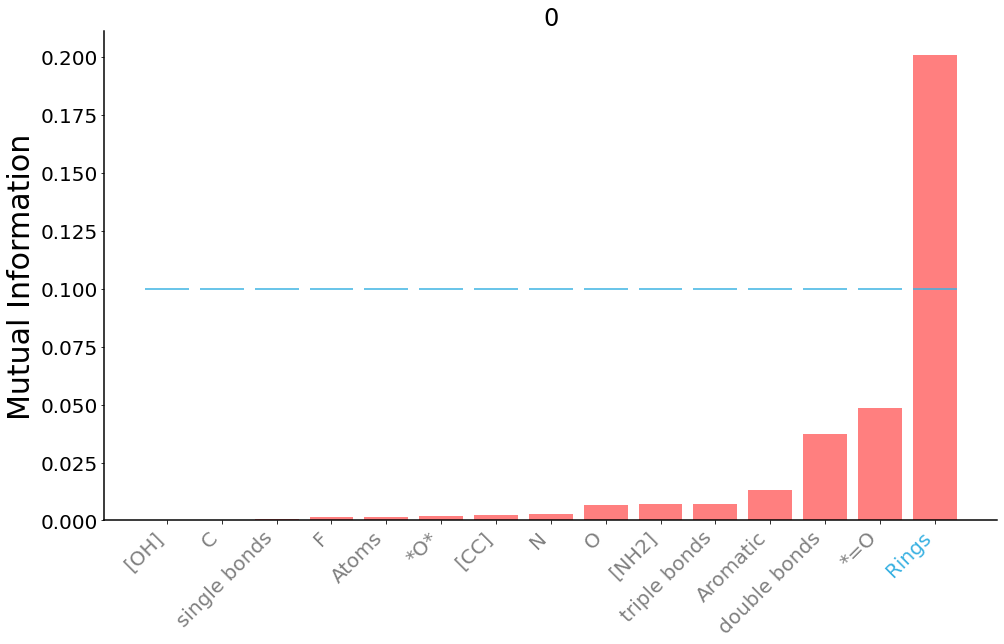

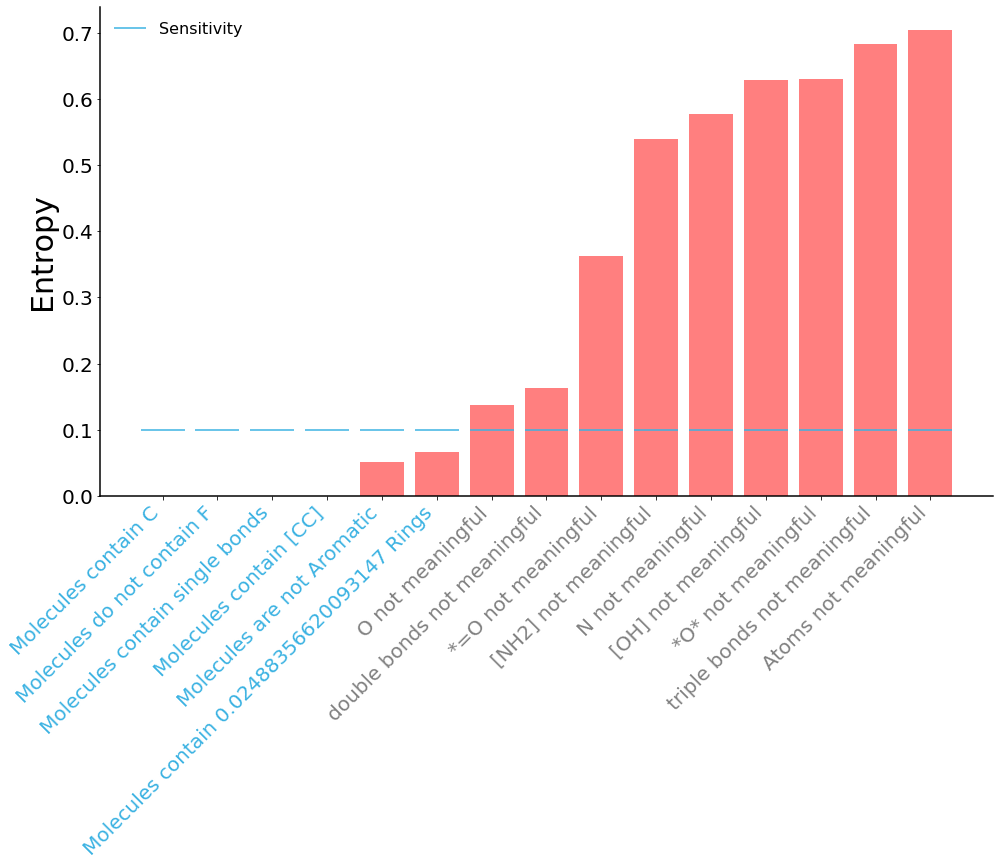

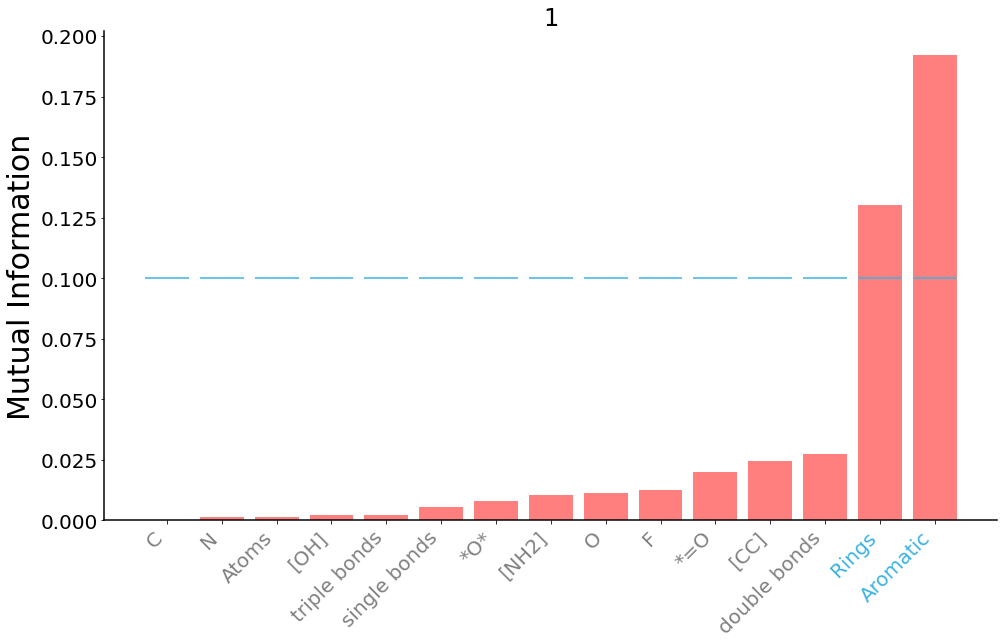

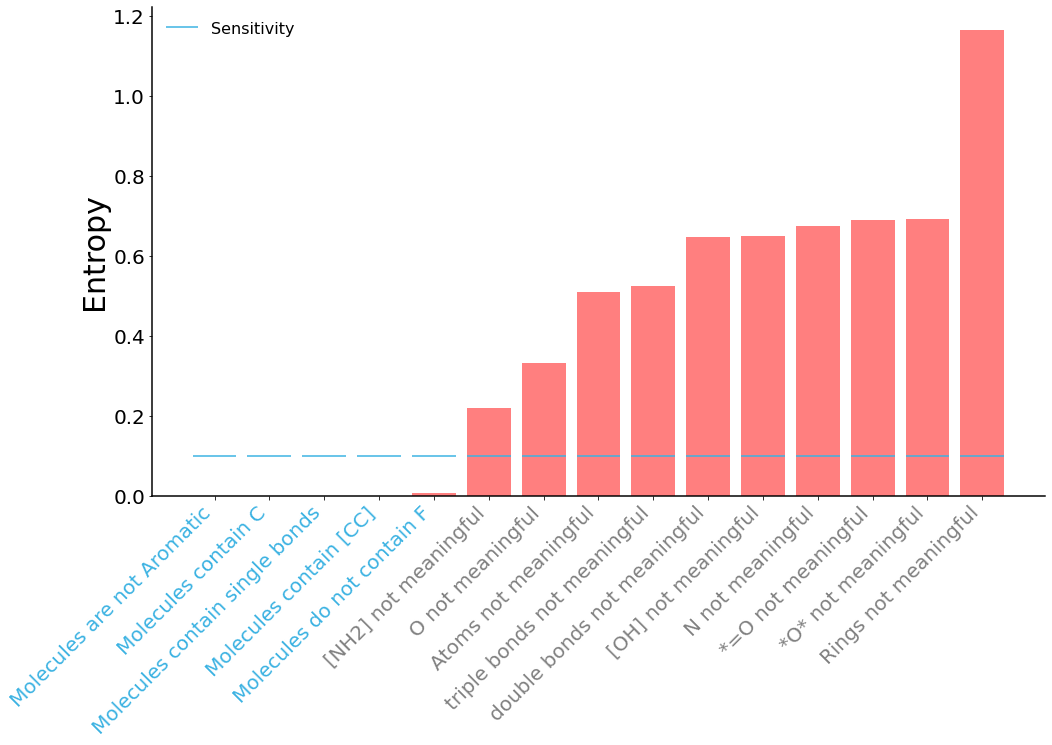

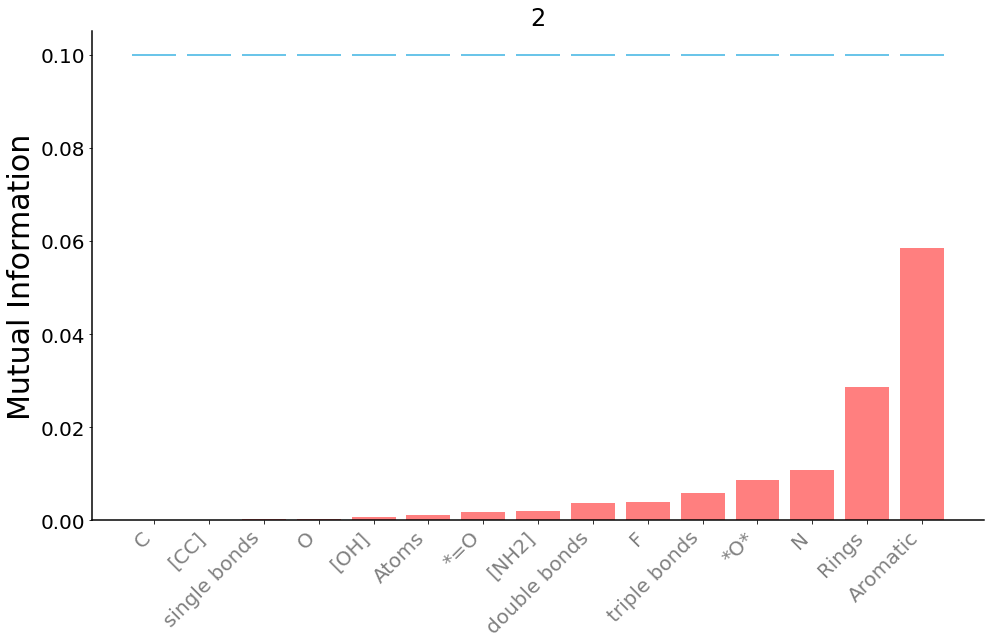

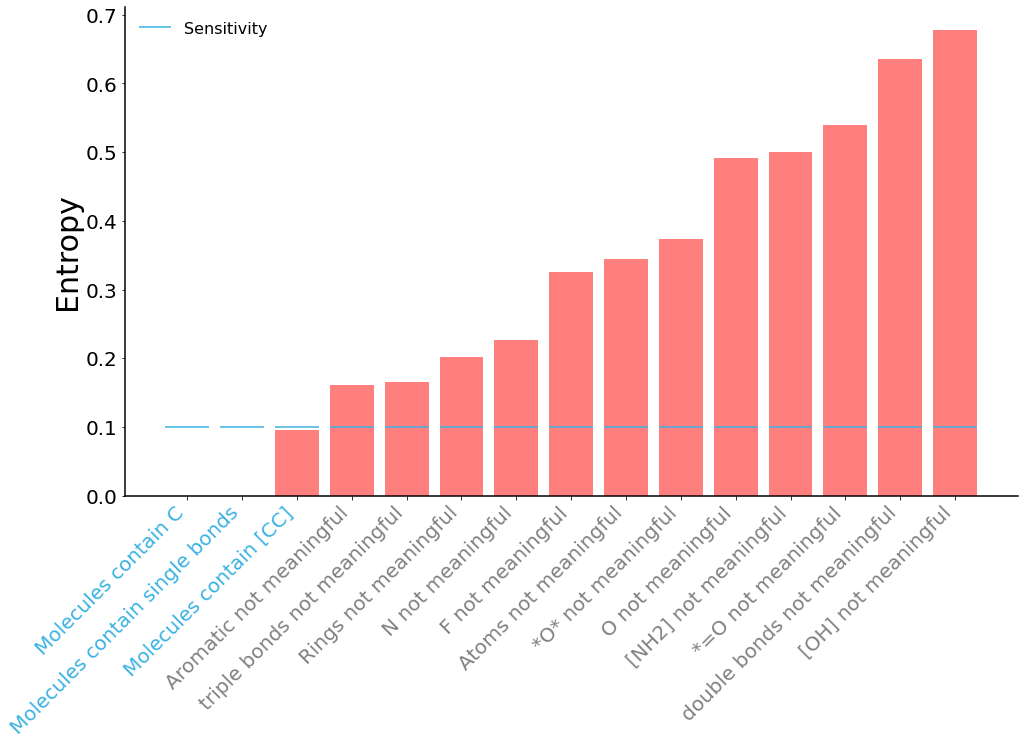

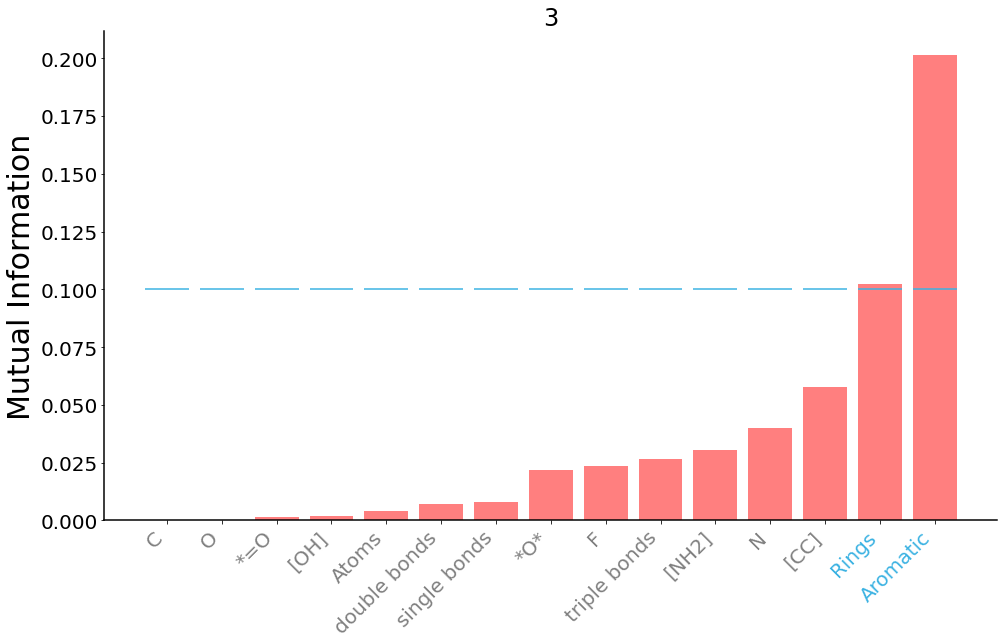

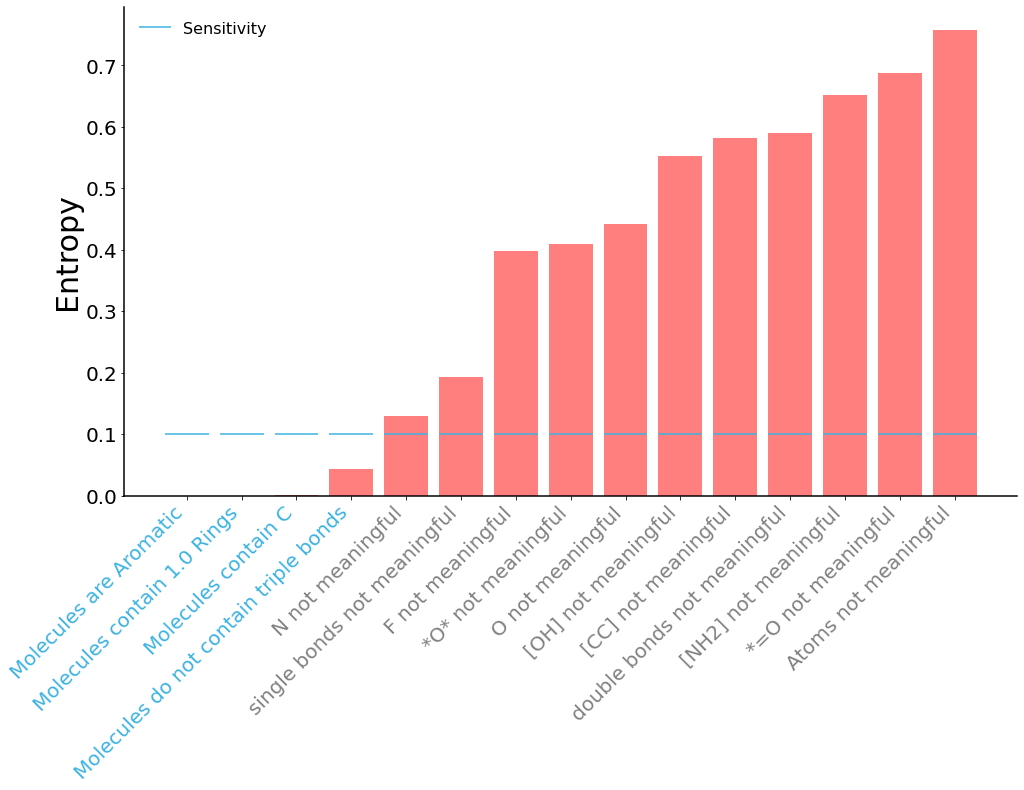

In [7]:
for i in range(4):
    space.plot_mi("Untrained",set_val=i)
    plt.title(f"{i}")
    plt.show()
    space.plot_entropy("Untrained",set_val=i)
    plt.show()

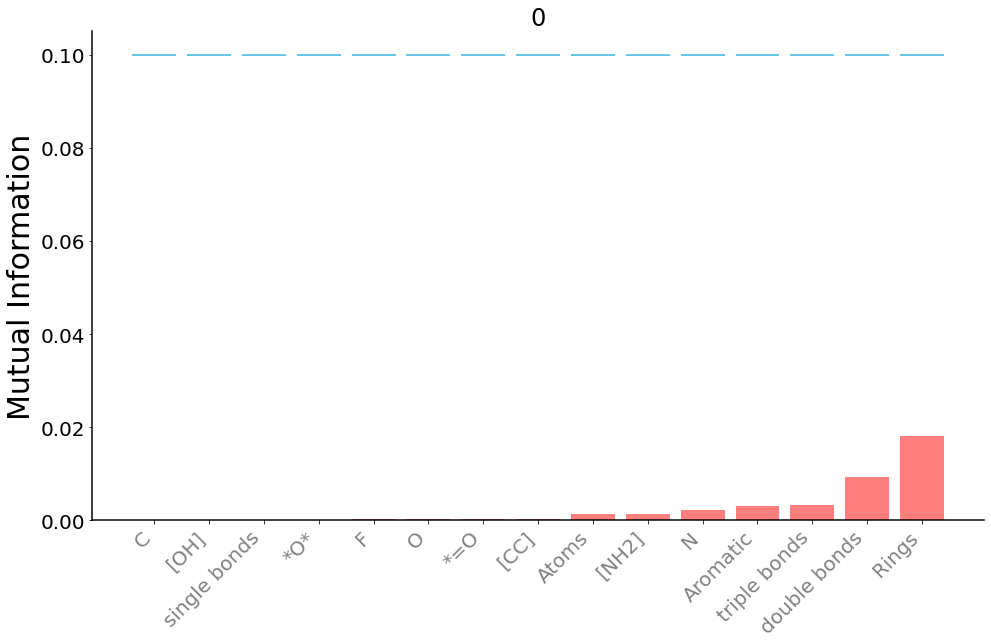

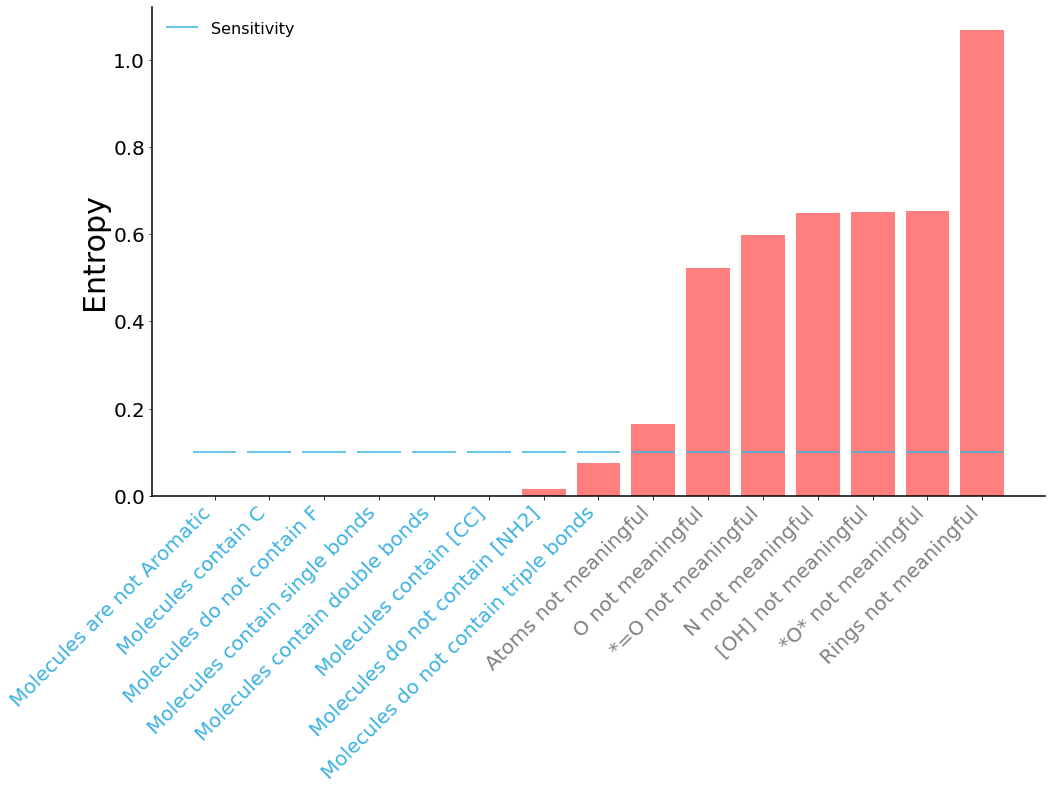

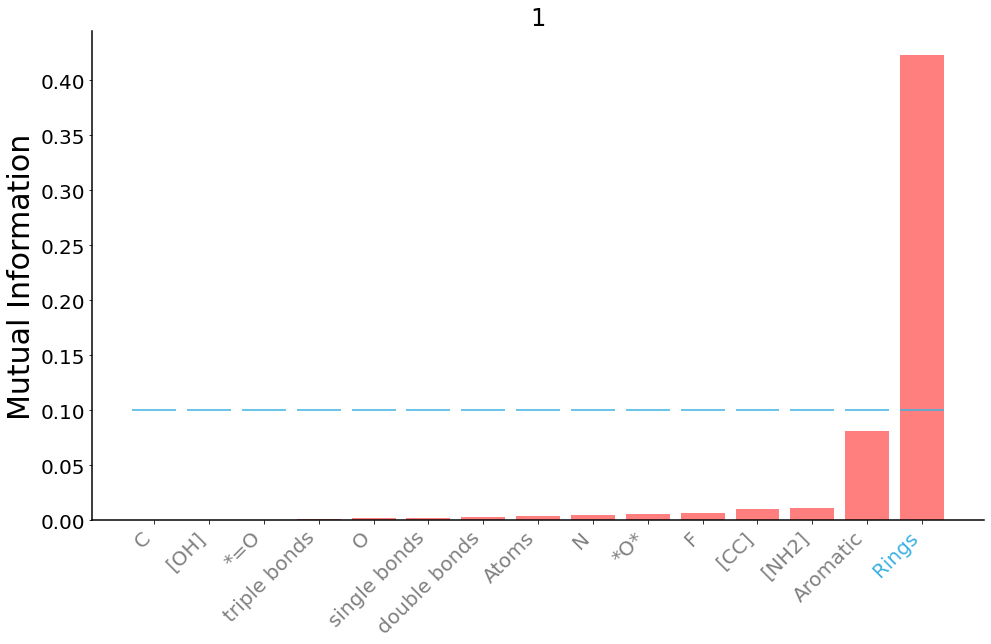

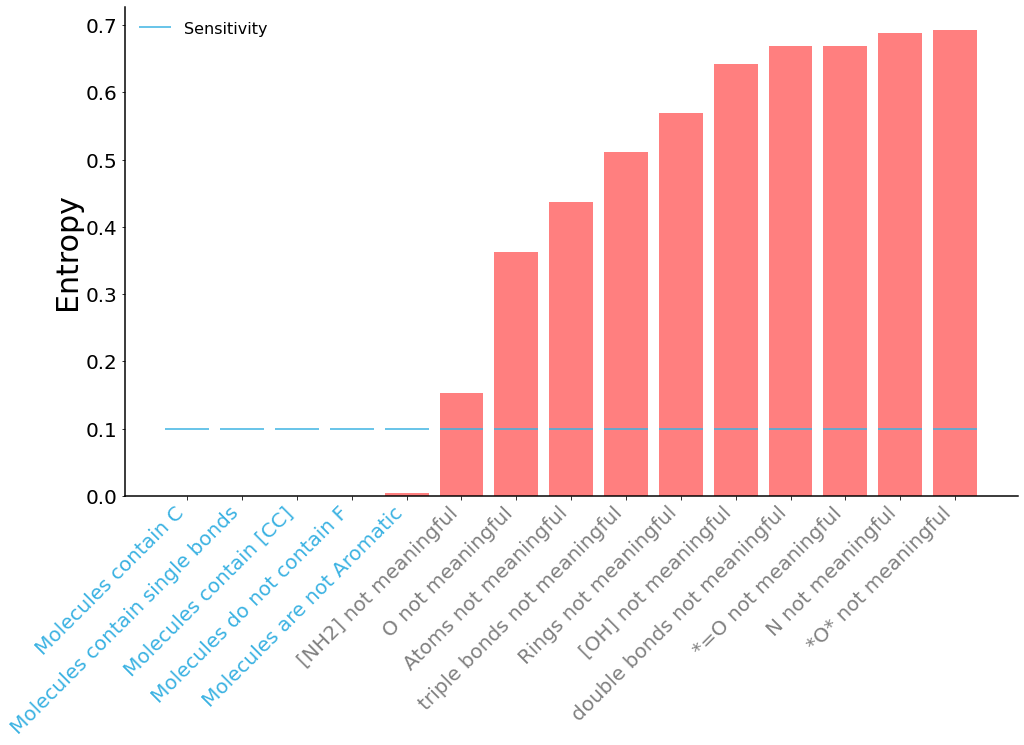

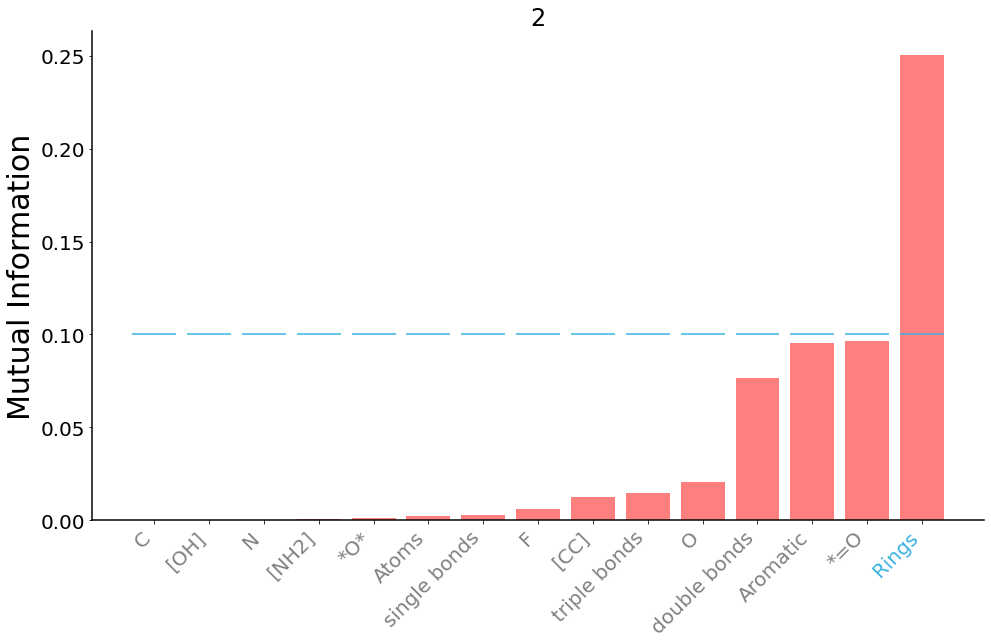

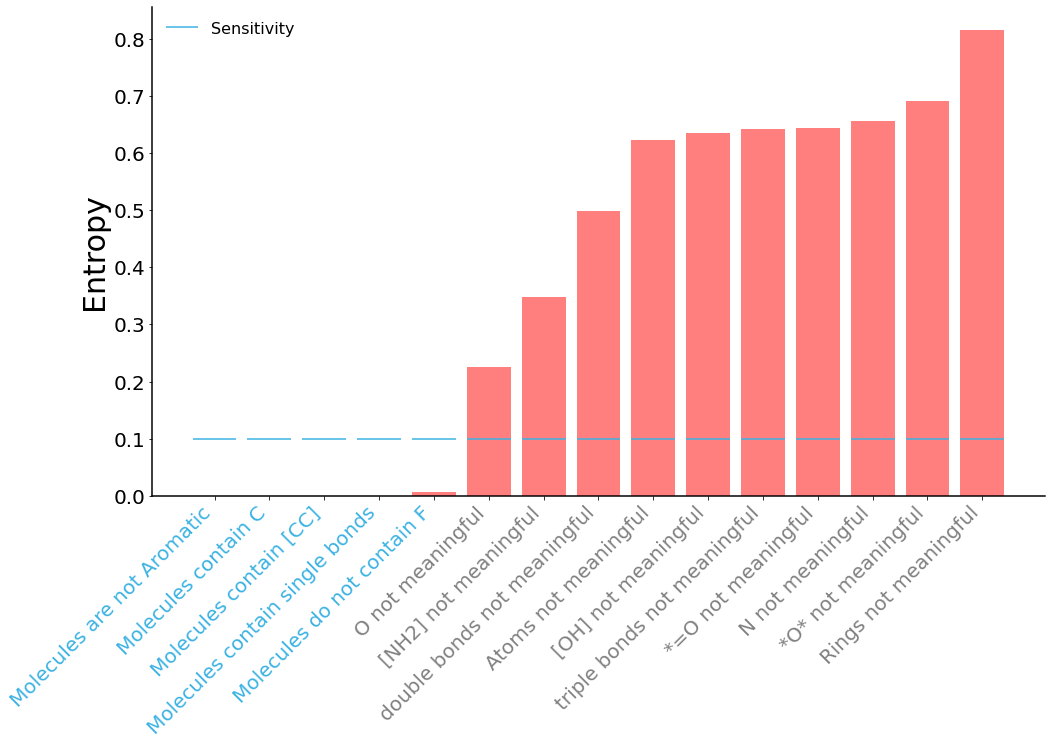

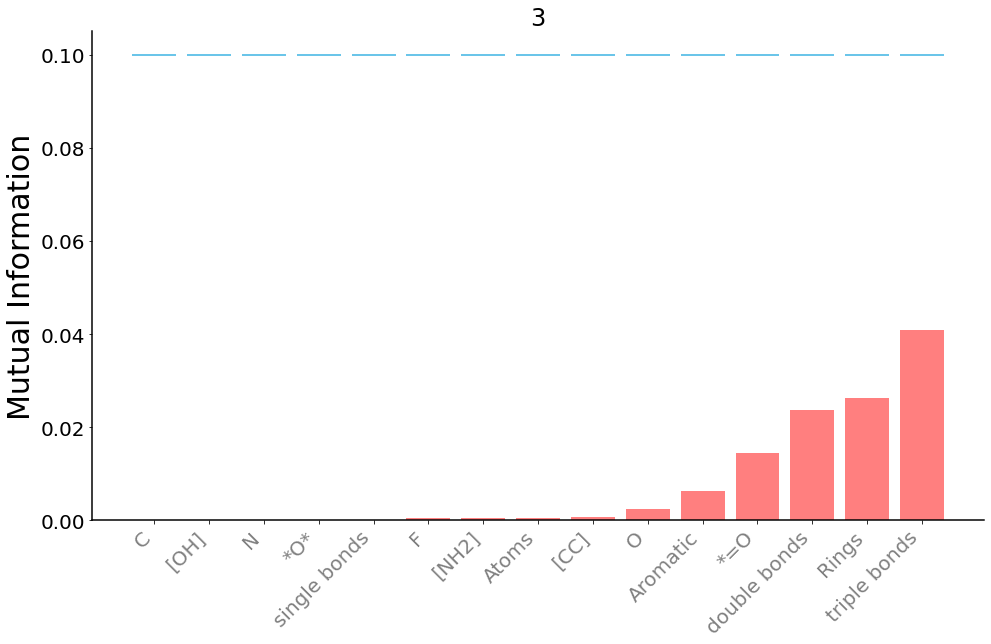

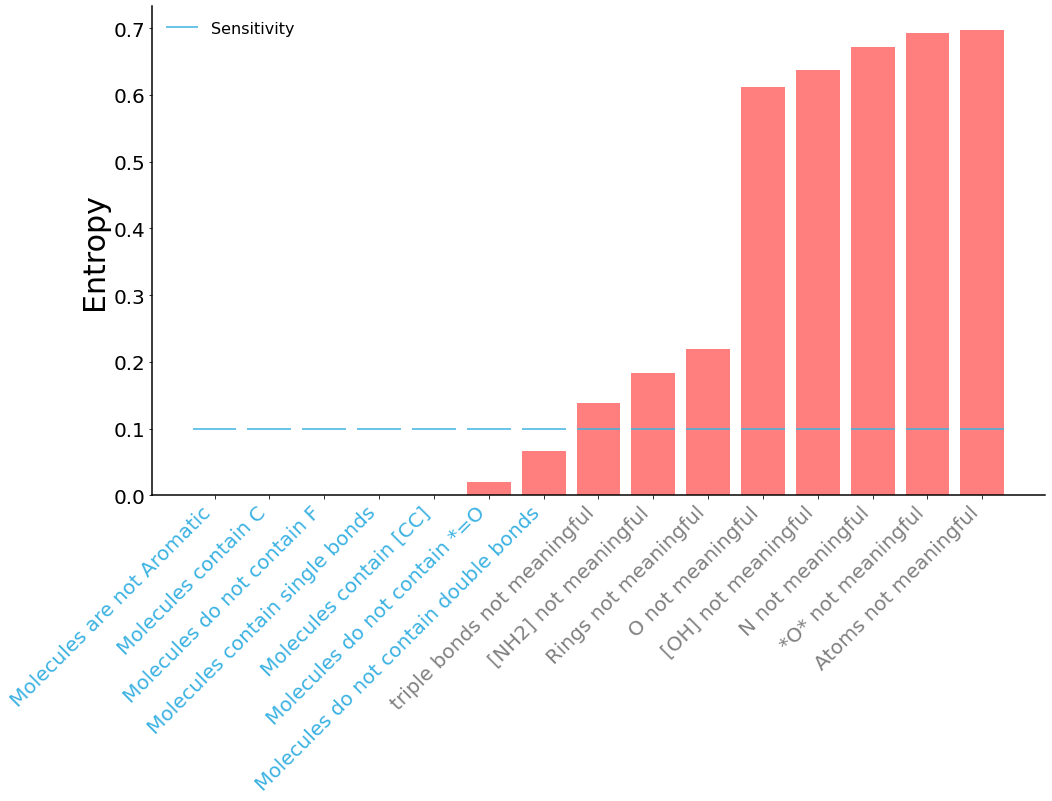

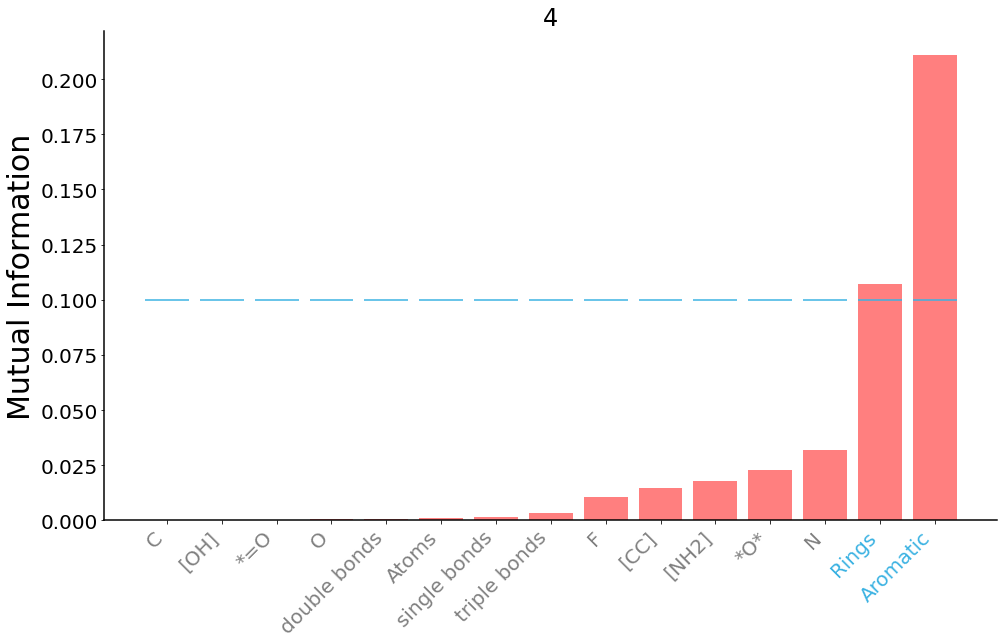

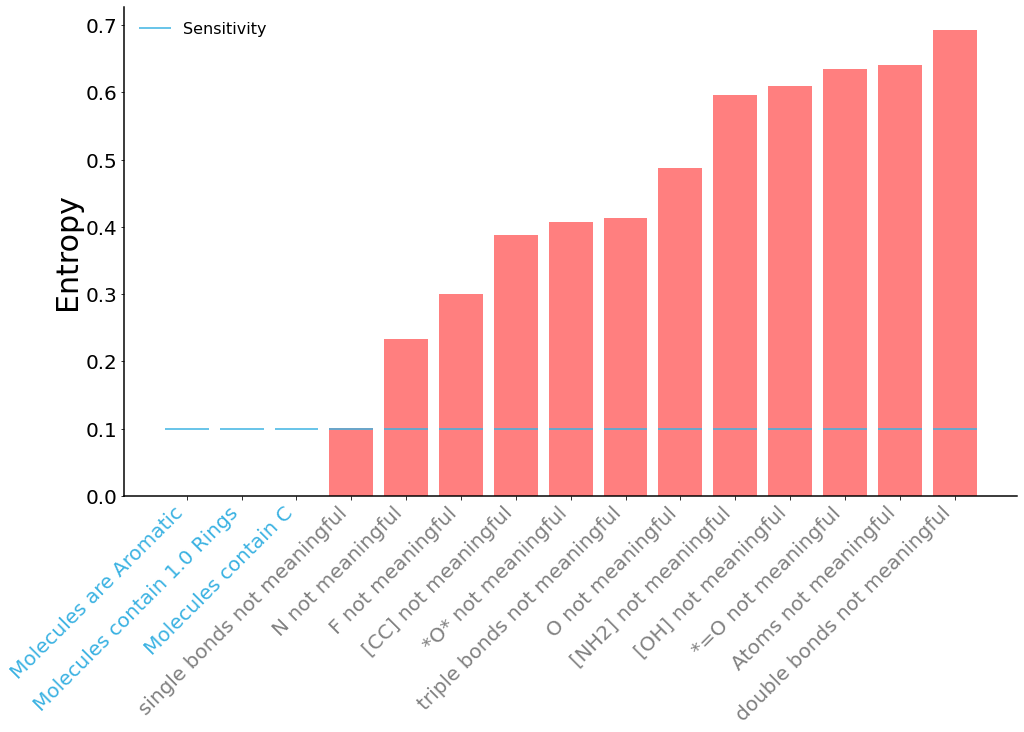

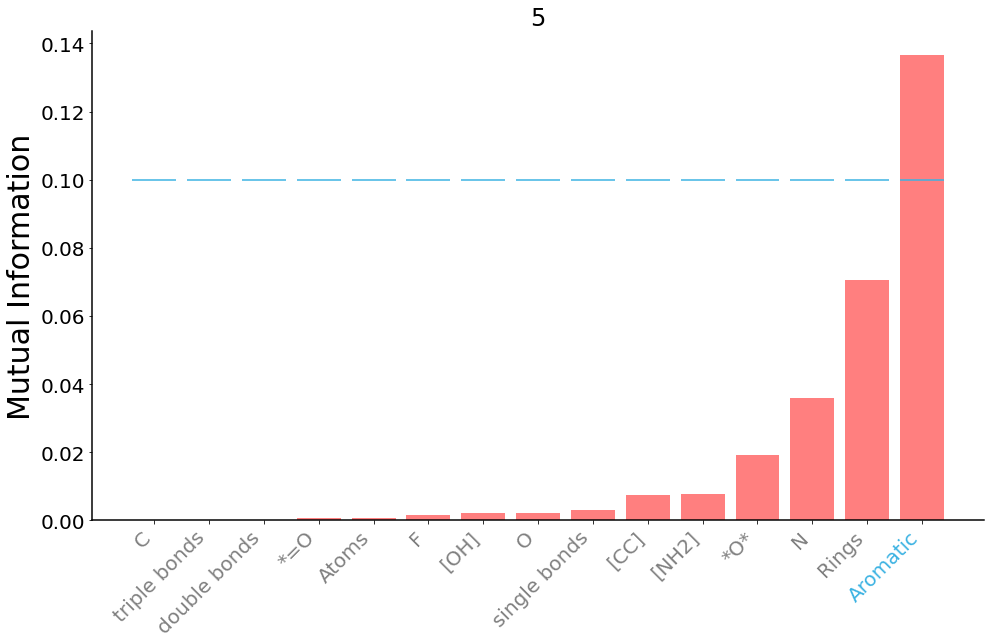

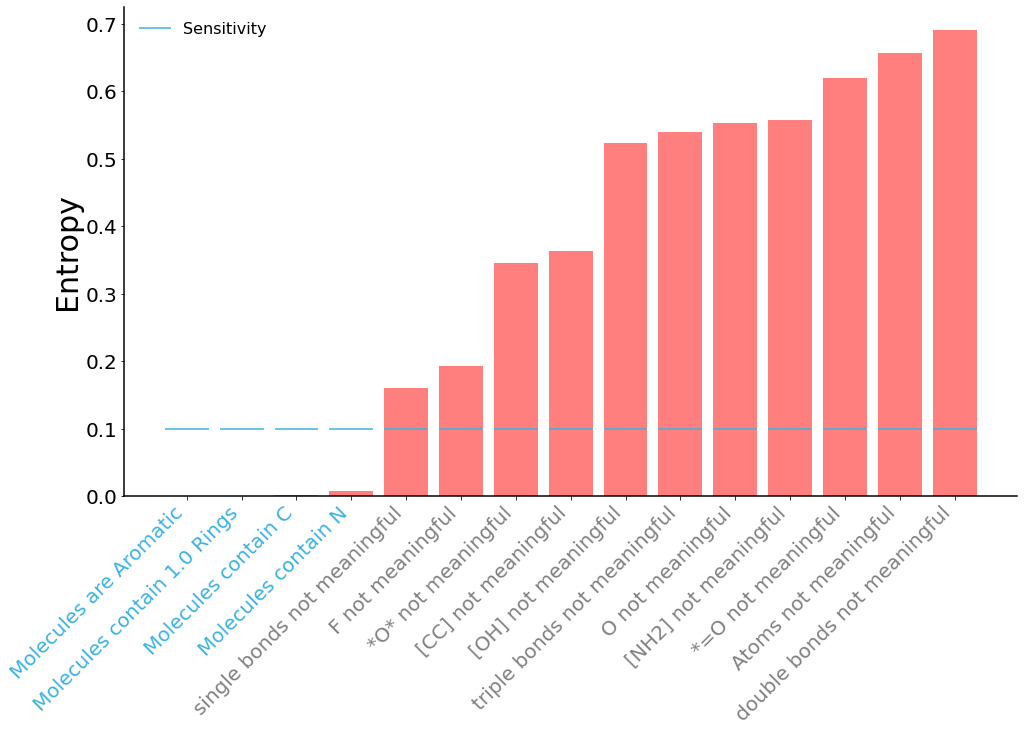

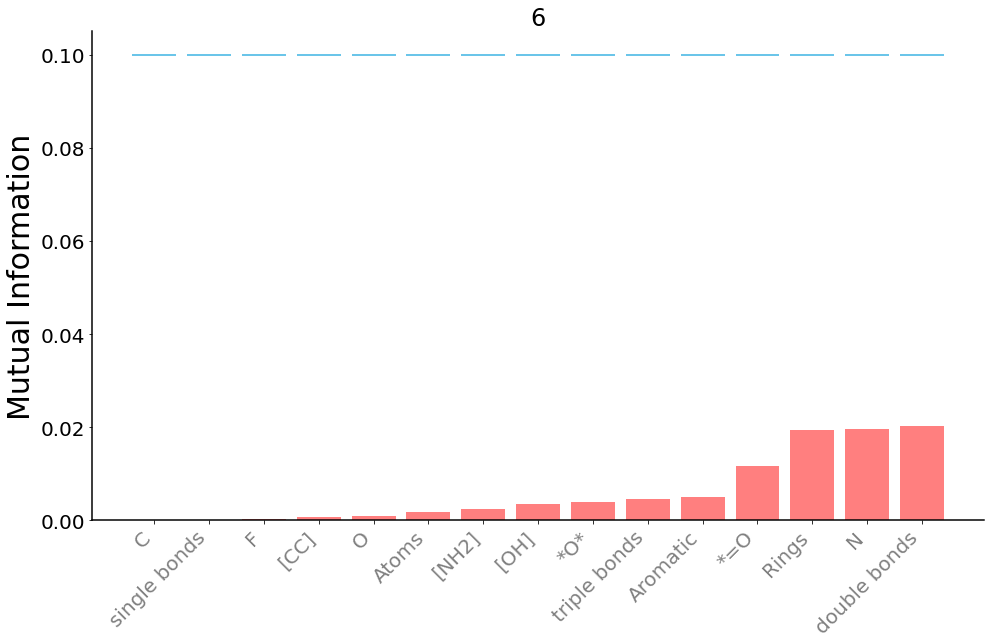

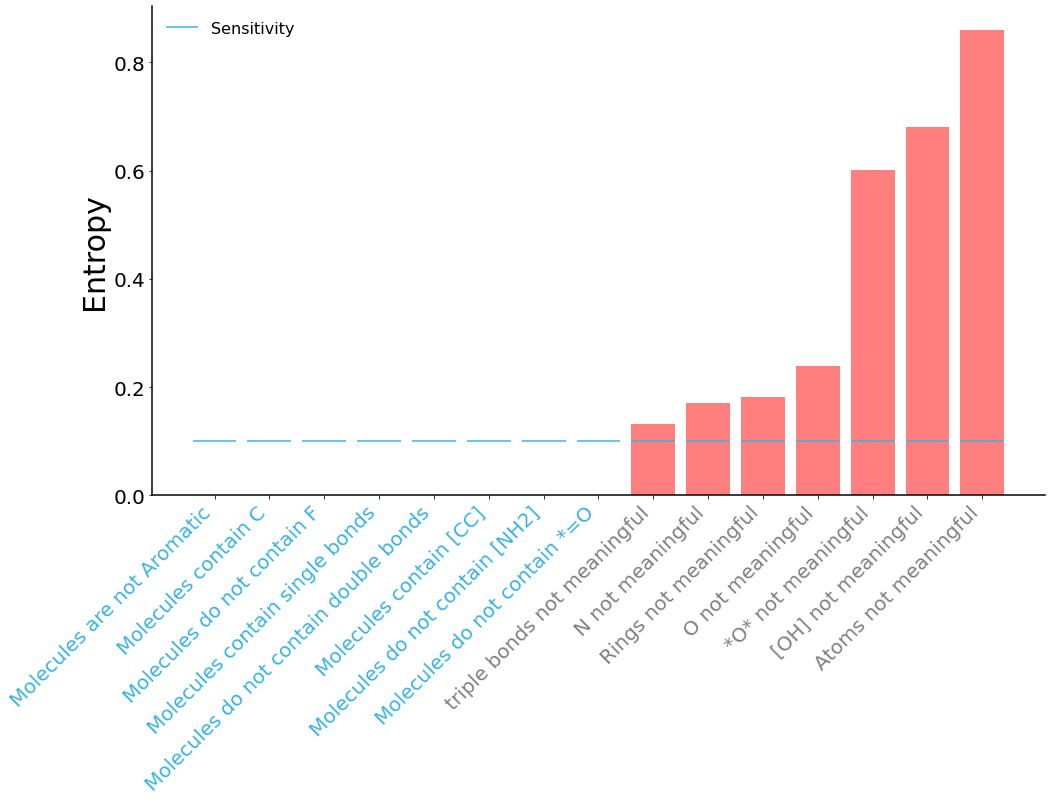

In [11]:
for i in range(7):
    space.plot_mi("Dipole",set_val=i)
    plt.title(f"{i}")
    plt.show()
    space.plot_entropy("Dipole",set_val=i)
    plt.show()

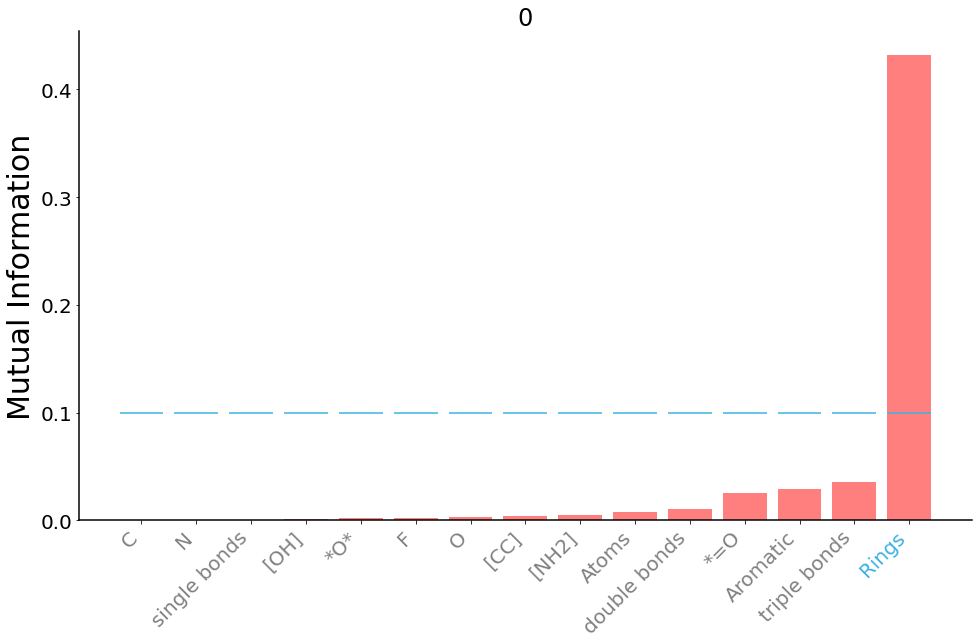

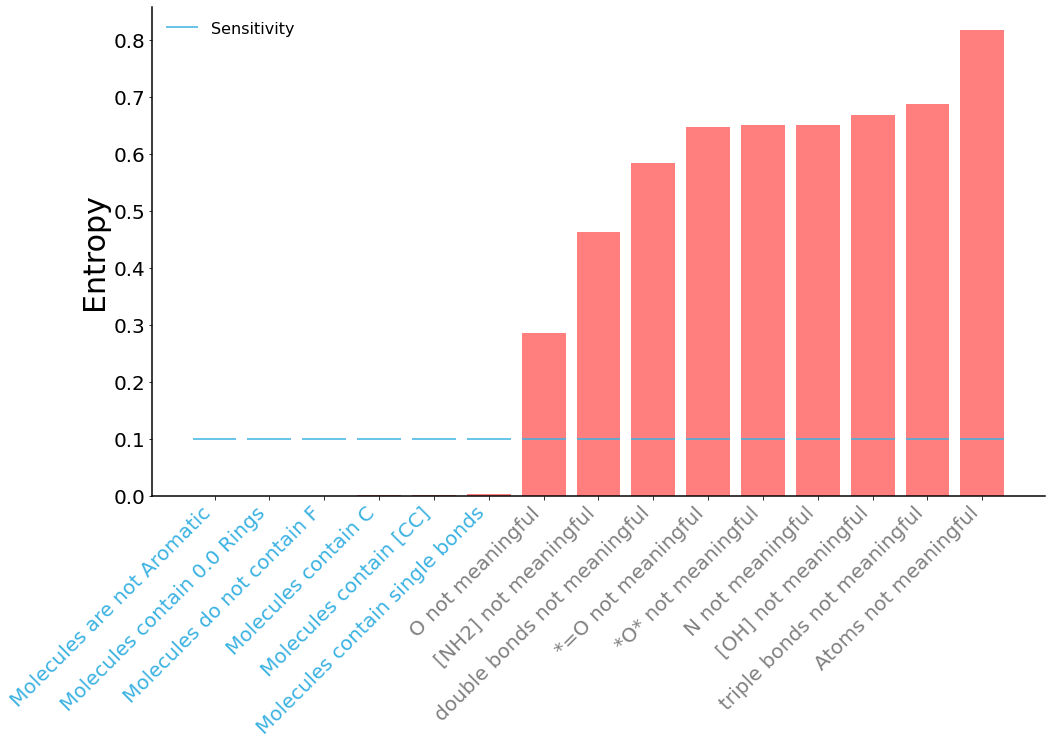

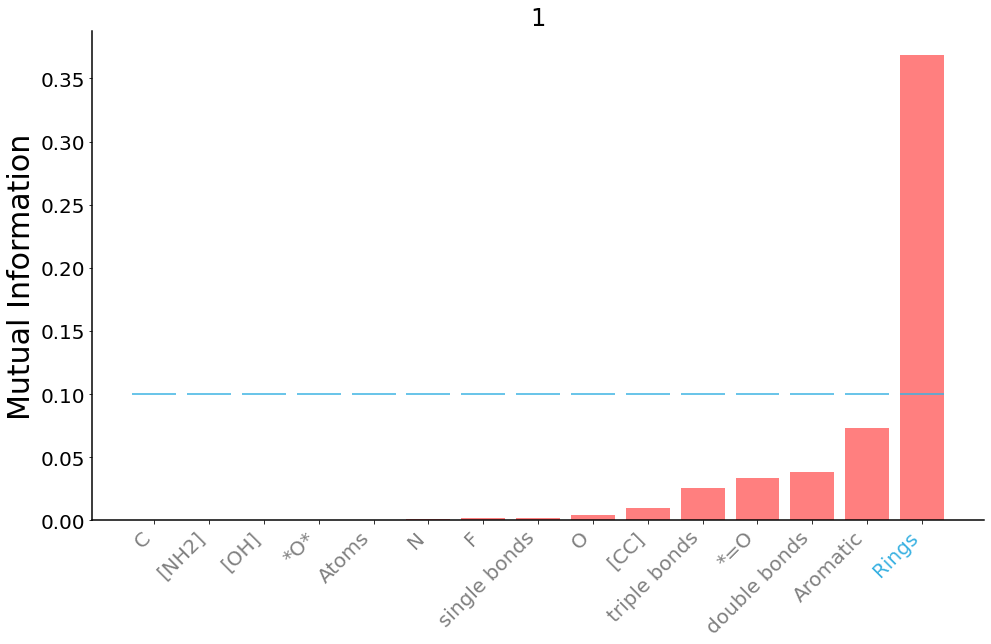

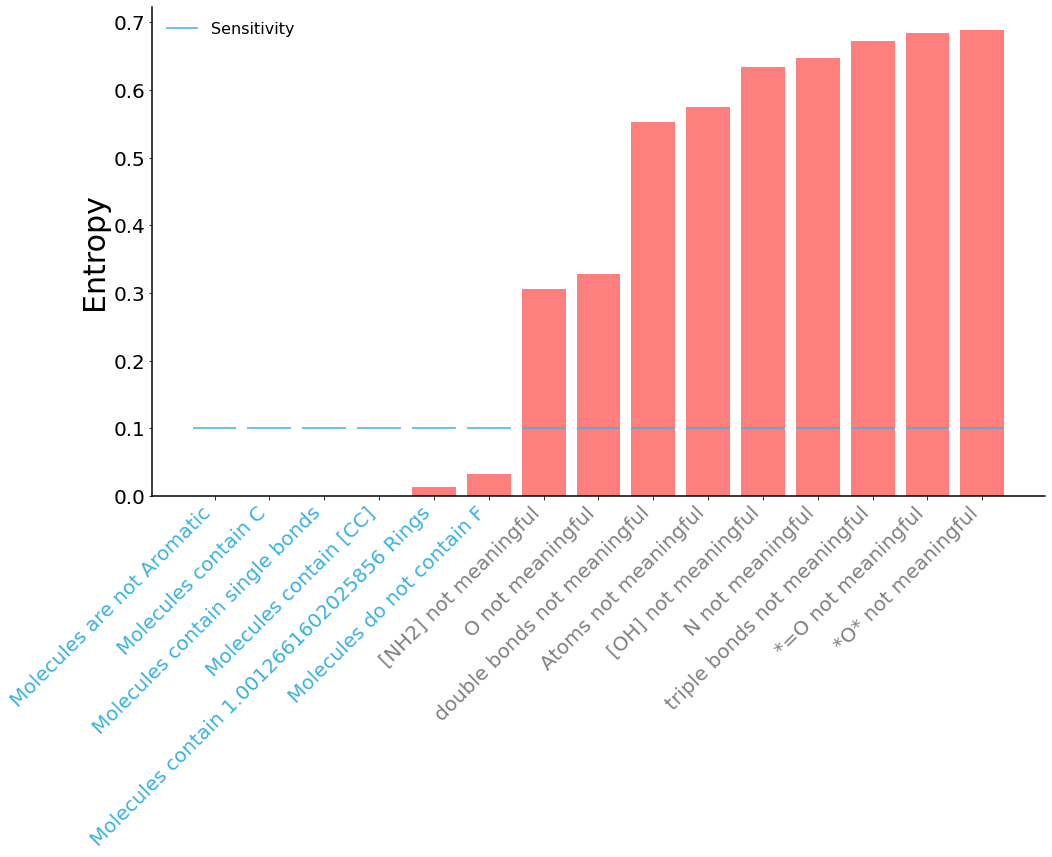

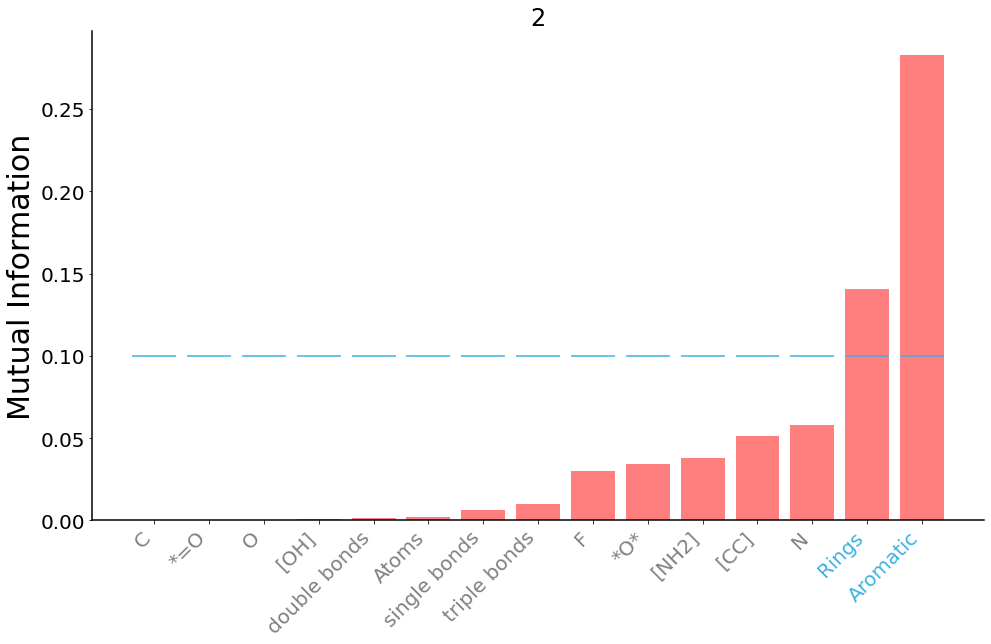

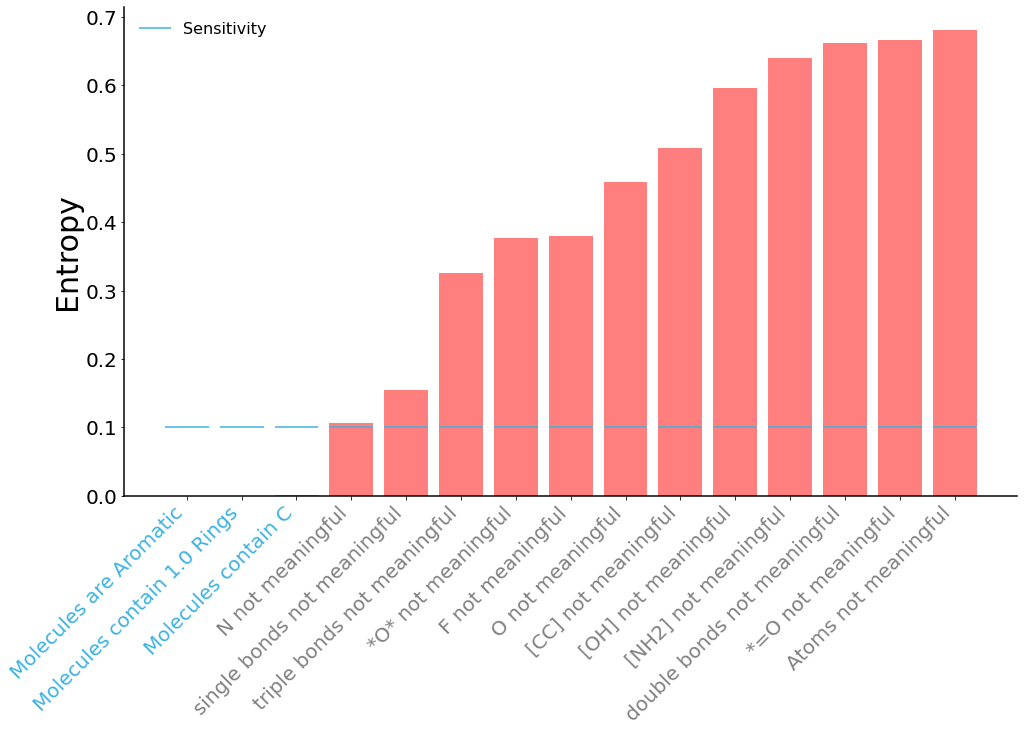

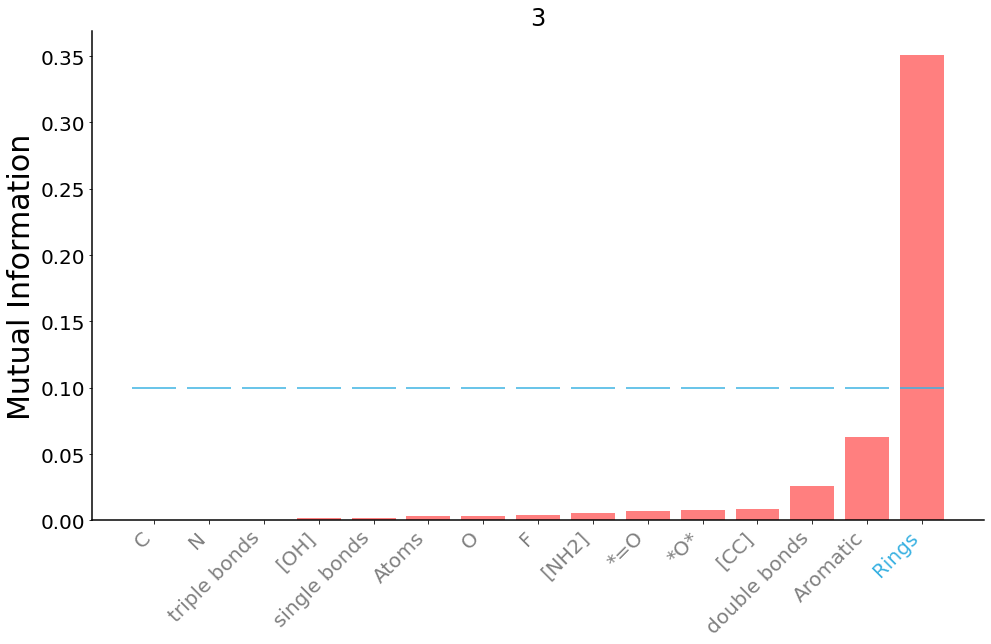

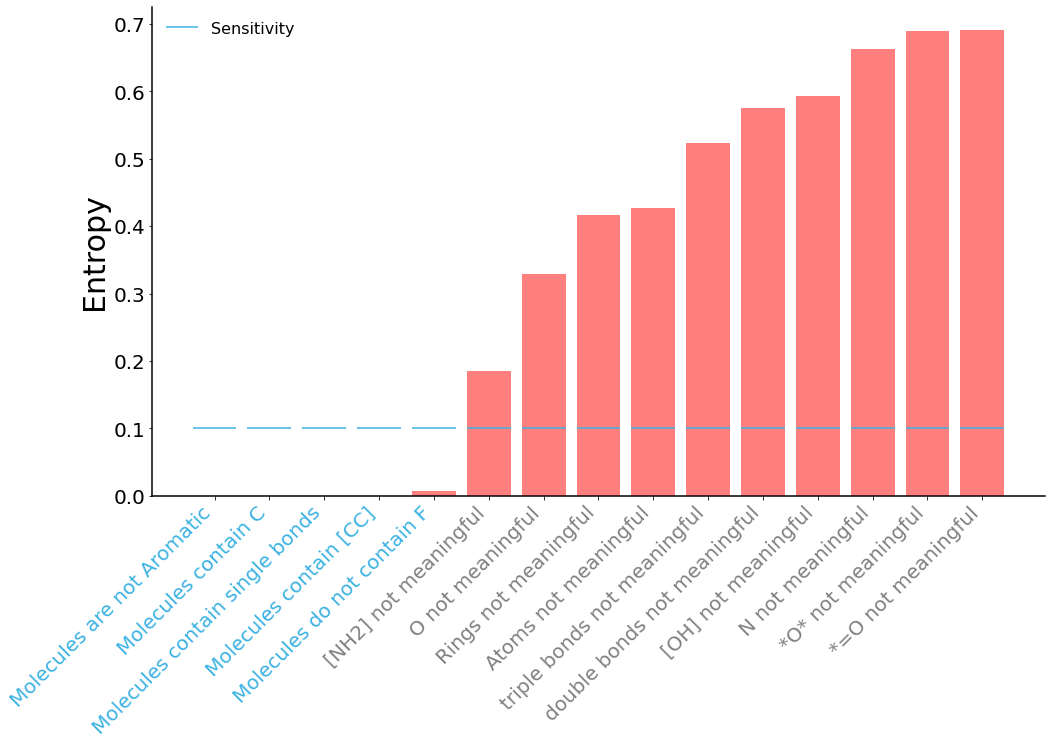

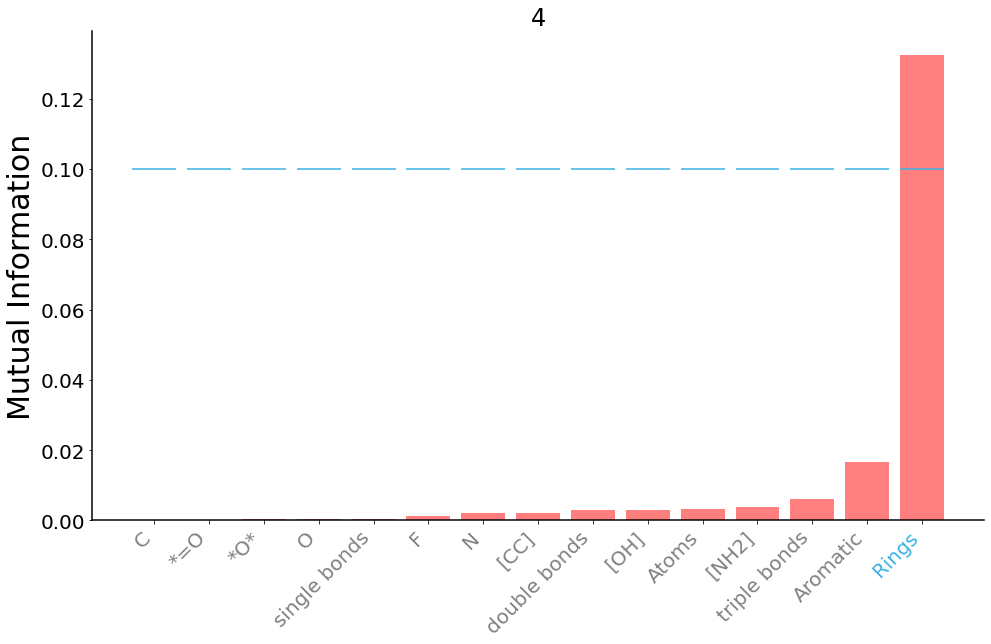

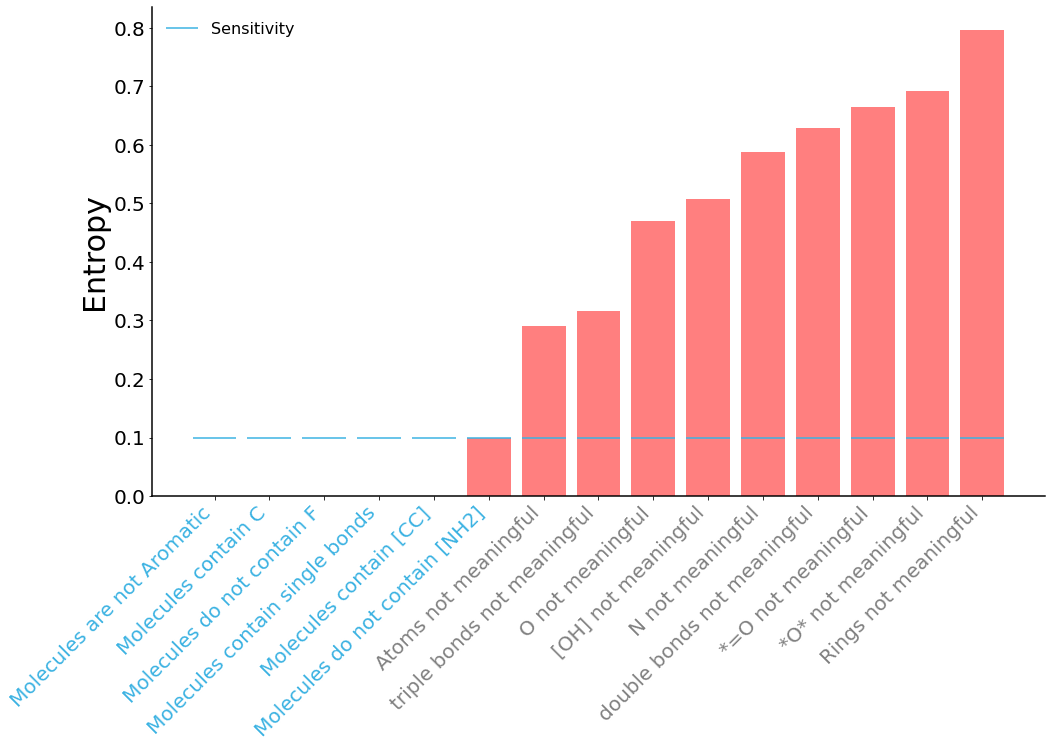

KeyError: 5

In [49]:
for i in range(6):
    space.plot_mi("isotropic",set_val=i)
    plt.title(f"{i}")
    plt.show()
    space.plot_entropy("isotropic",set_val=i)
    plt.show()

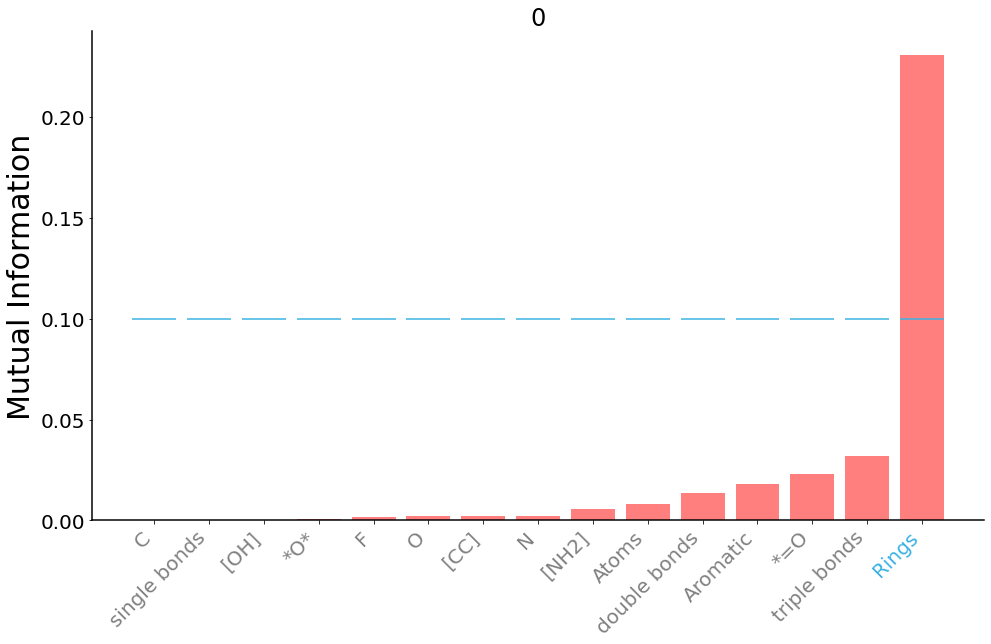

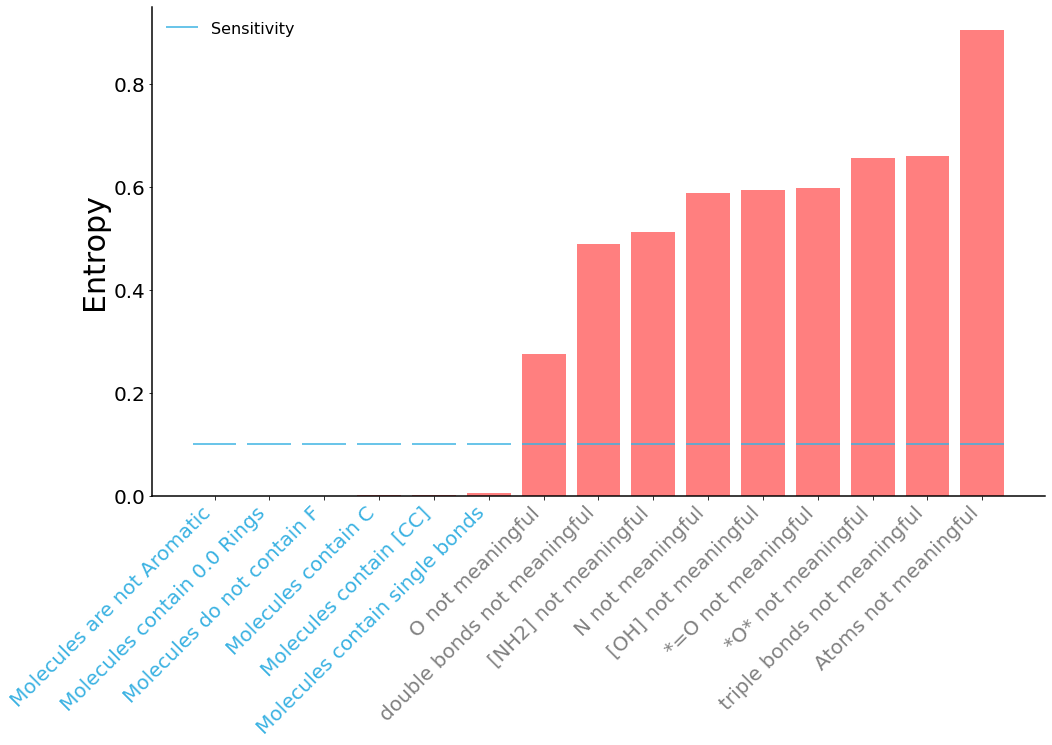

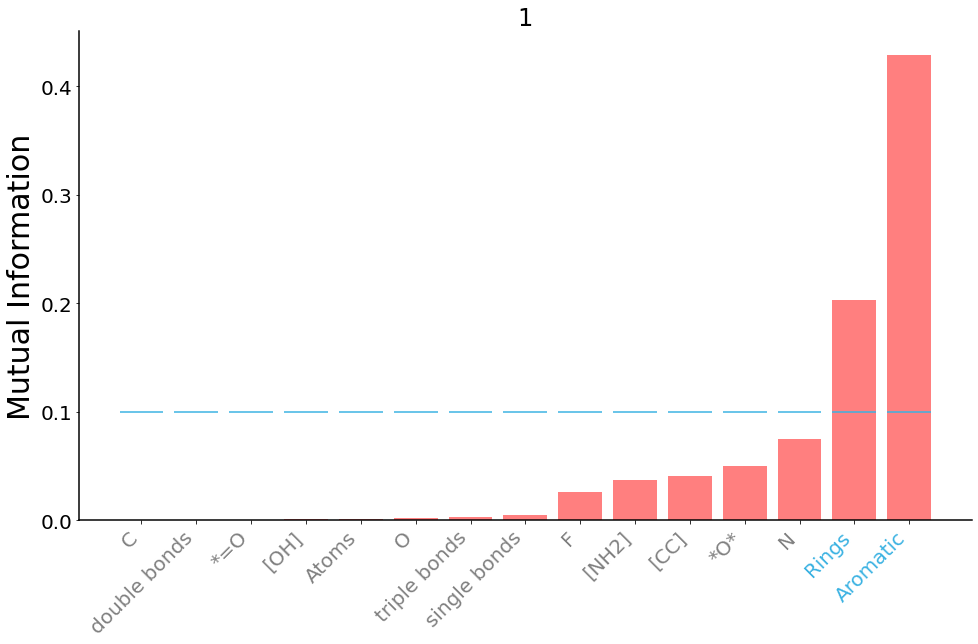

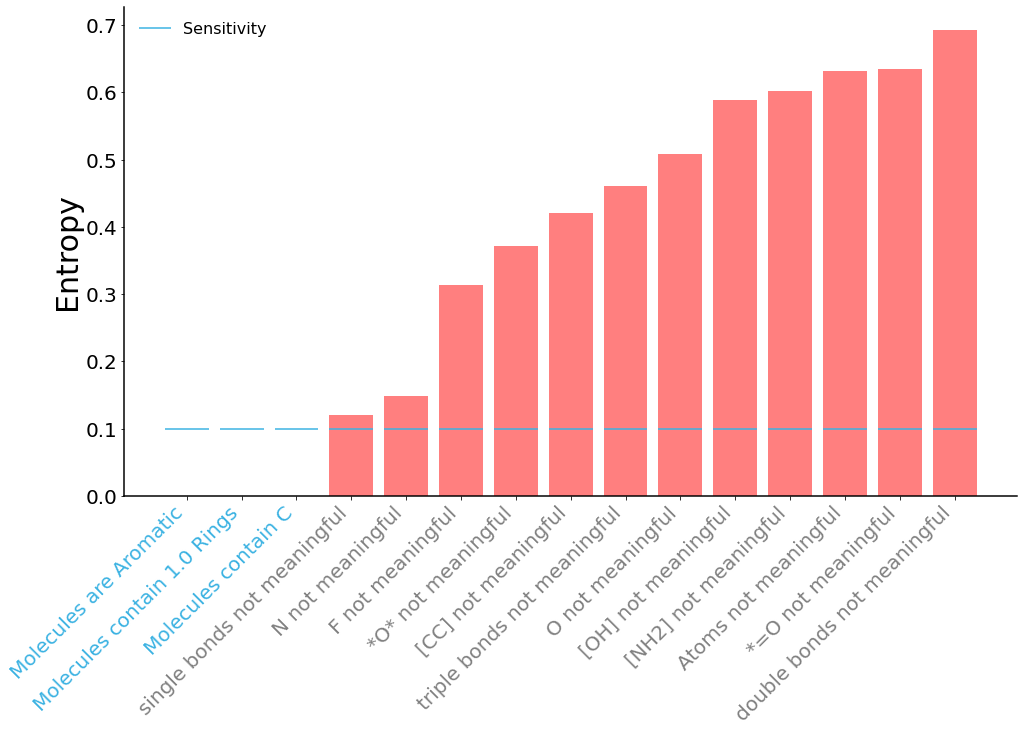

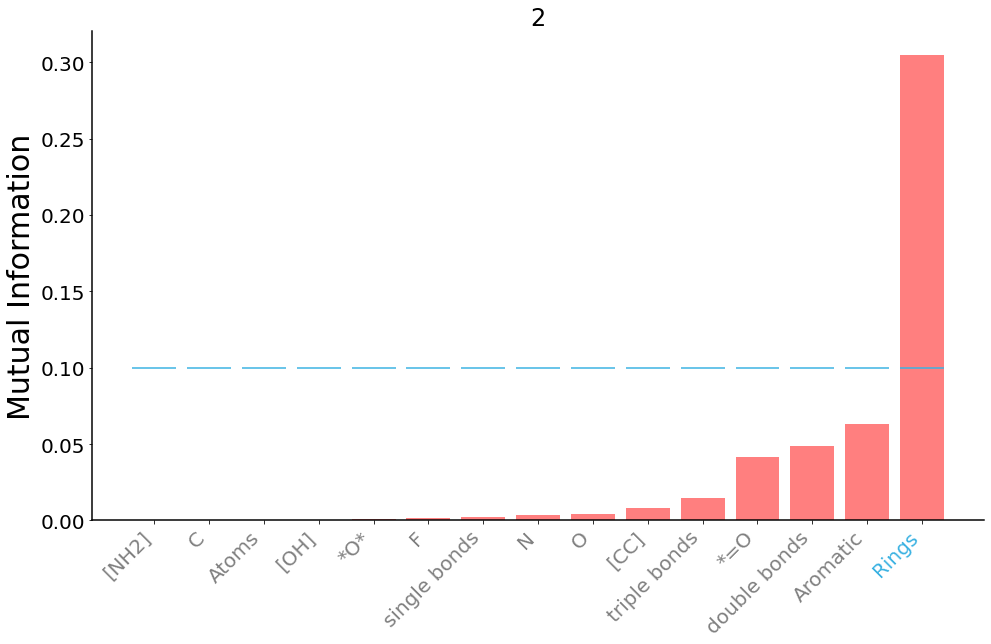

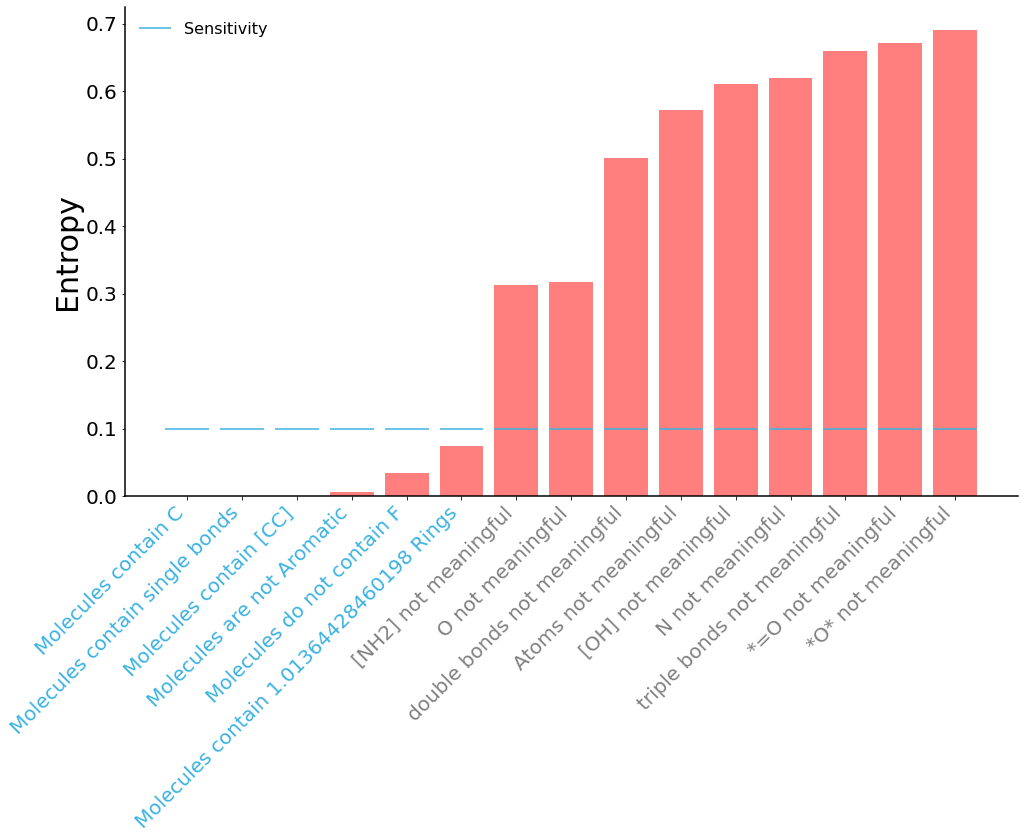

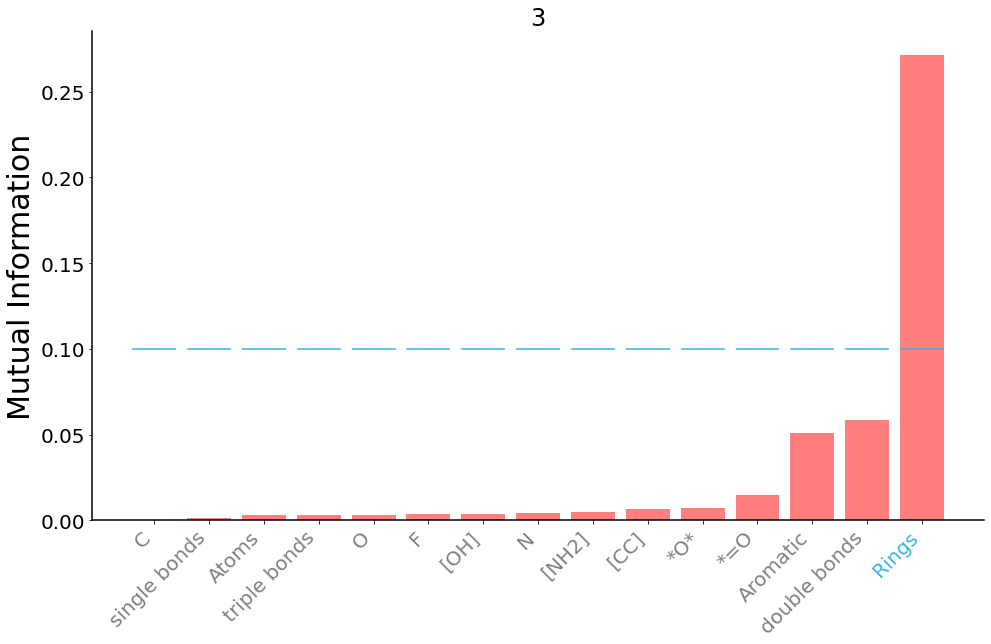

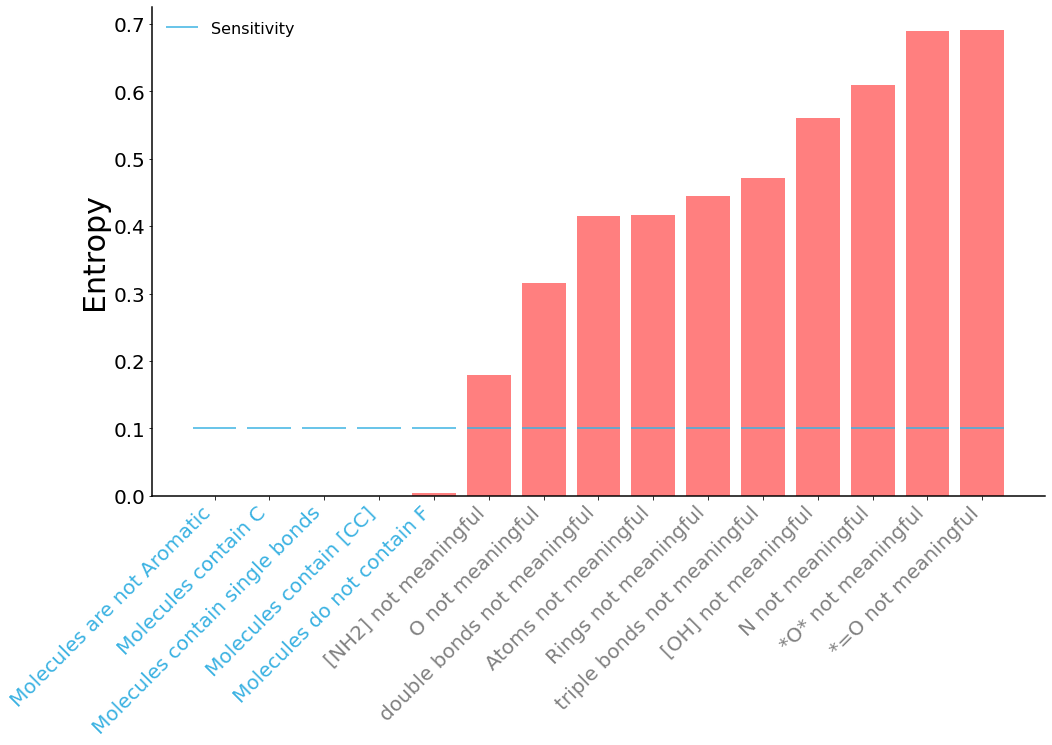

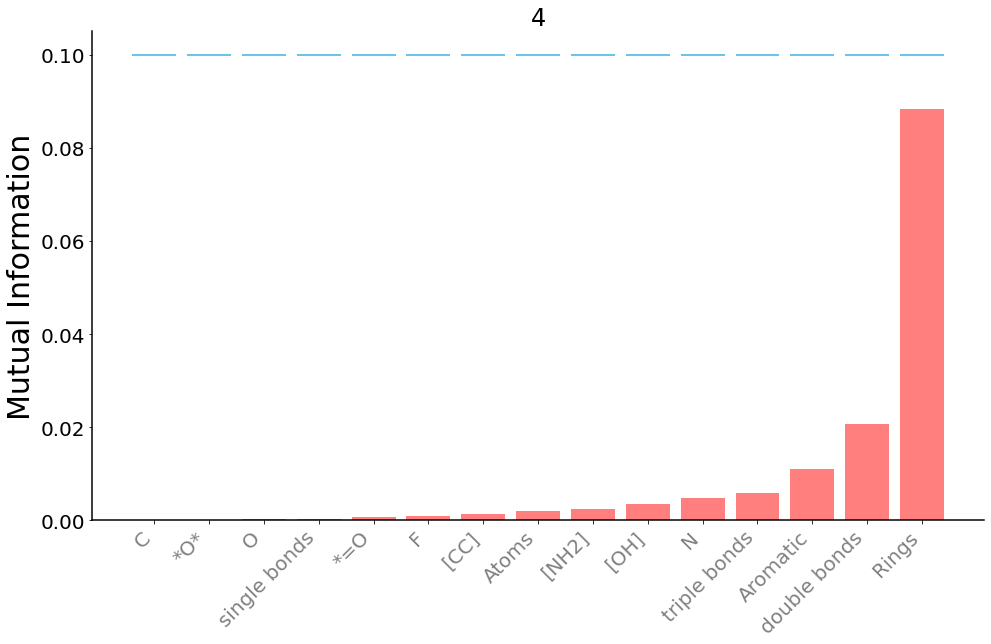

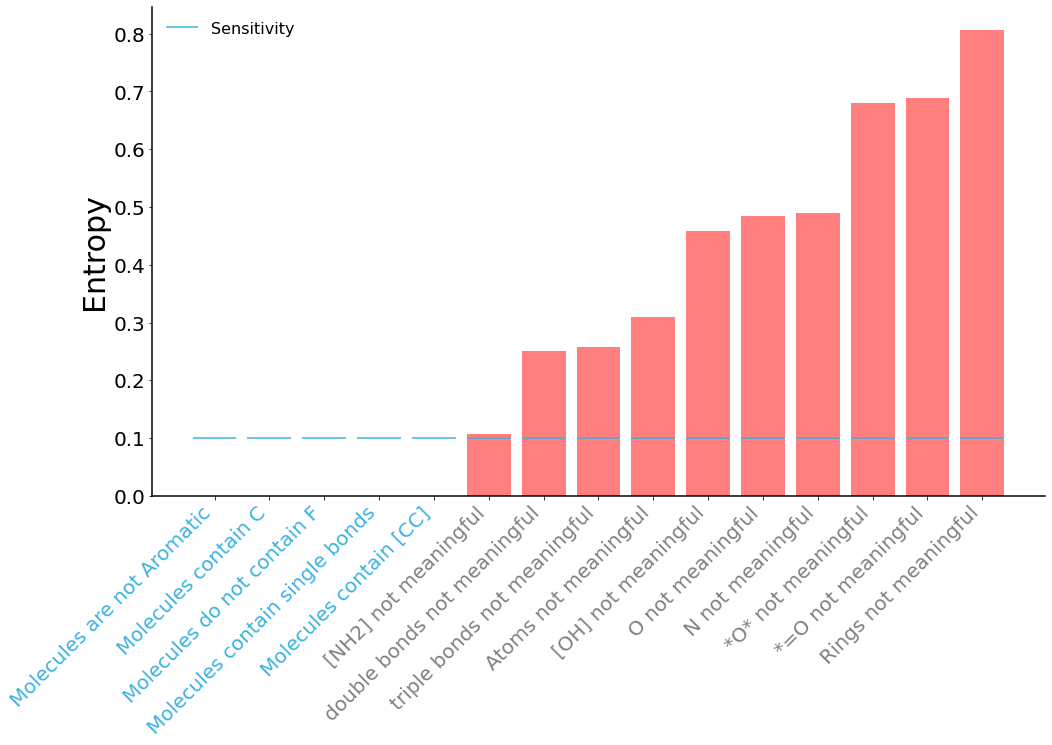

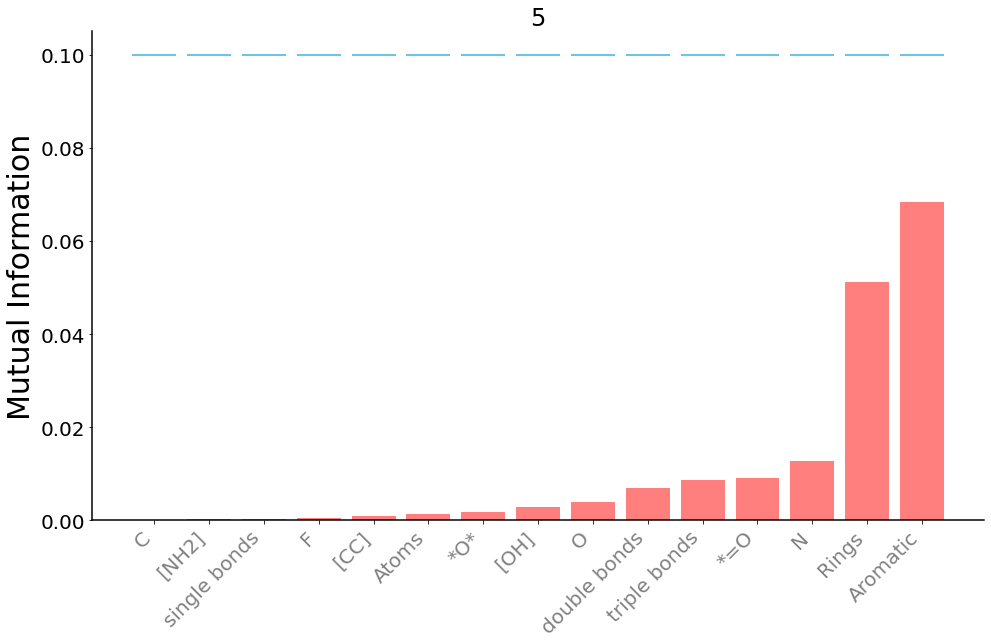

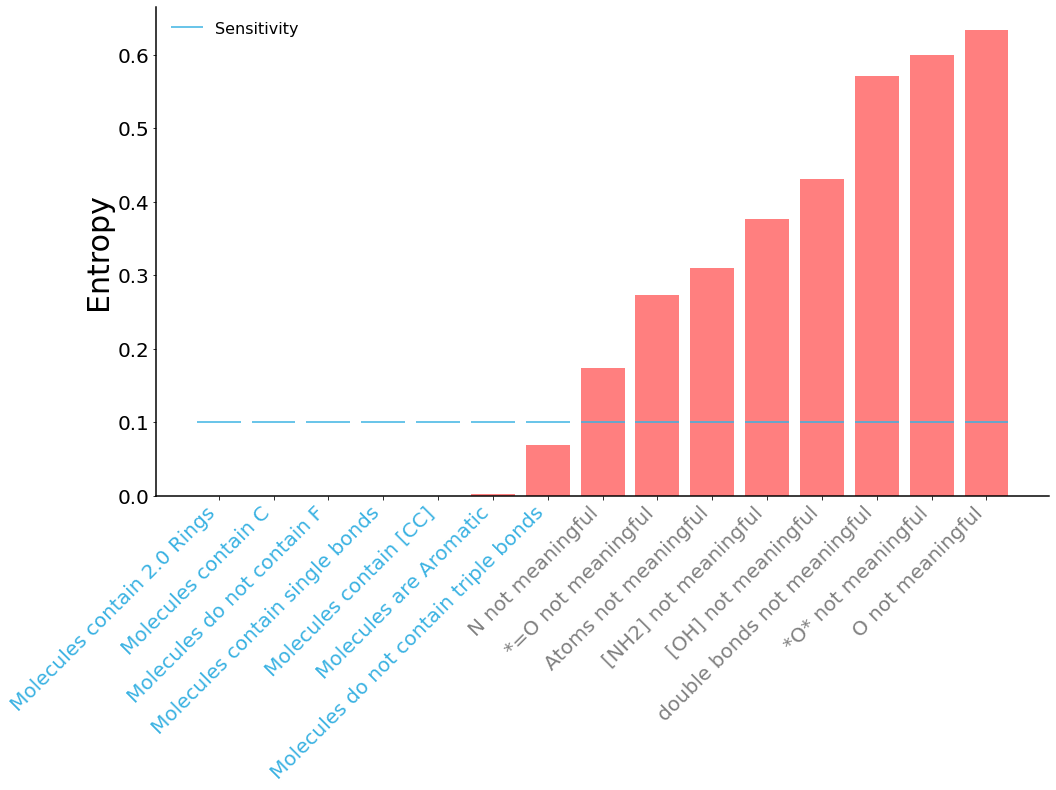

In [6]:
for i in range(6):
    space.plot_mi("gap",set_val=i)
    plt.title(f"{i}")
    plt.show()
    space.plot_entropy("gap",set_val=i)
    plt.show()

In [73]:
space.mi("DBSCAN",set_val=4,prop="Rings",return_contingency=True)

(0.049794501658989535,
 array([[    0,     0,  3448,     0,     0,     0,     0,     0,     0],
        [13998, 53401, 32888, 19760,  5772,  3569,   781,   232,    36]]))

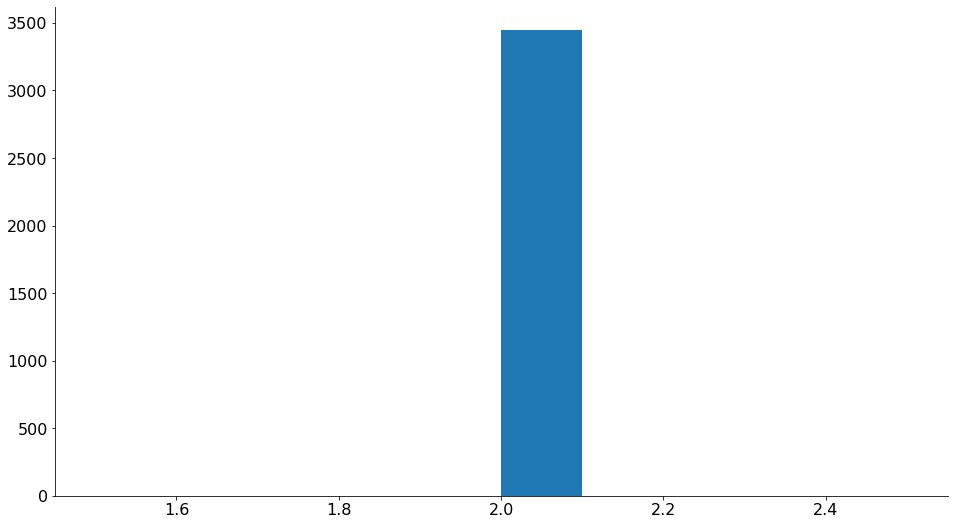

In [74]:
plt.hist(space.data.loc[space["DBSCAN"][4]]["Rings"])
plt.show()

(0.3658166960459911, array([[11827,     0,     0,     0,     0,     0,     0,     0,     0],
       [ 2171, 53401, 36336, 19760,  5772,  3569,   781,   232,    36]]))


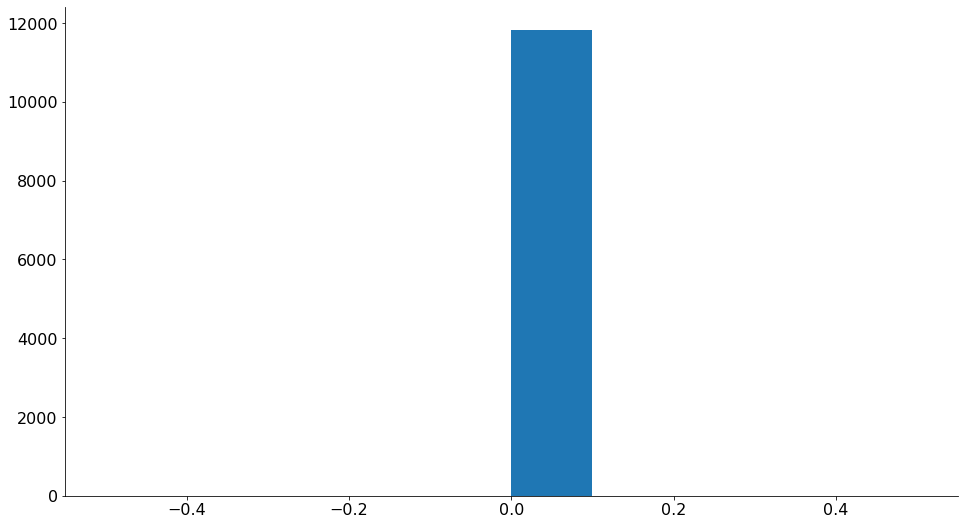

(0.36321260749963946, array([[    2, 29508,    24,     0,     0,     0,     0,     0,     0],
       [13996, 23893, 36312, 19760,  5772,  3569,   781,   232,    36]]))


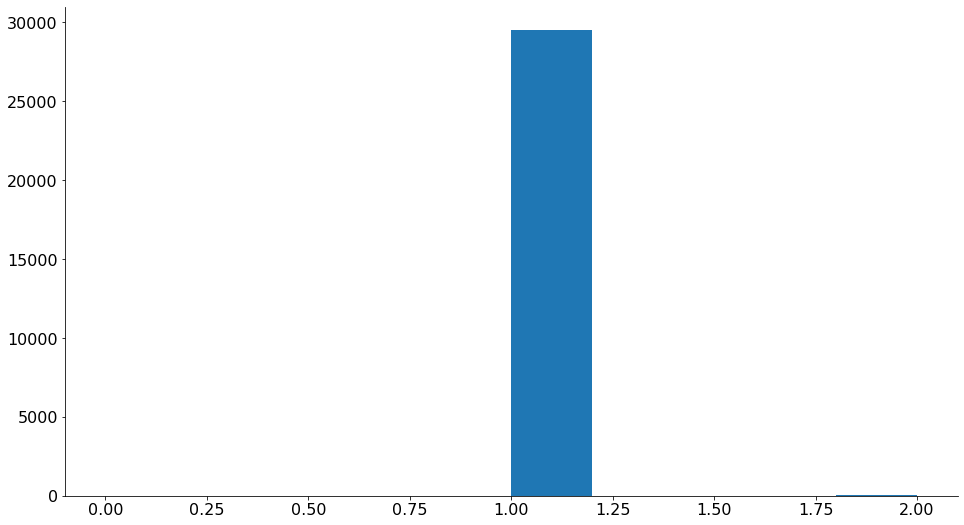

(0.17337984084324817, array([[    0, 15738,     0,     0,     0,     0,     0,     0,     0],
       [13998, 37663, 36336, 19760,  5772,  3569,   781,   232,    36]]))


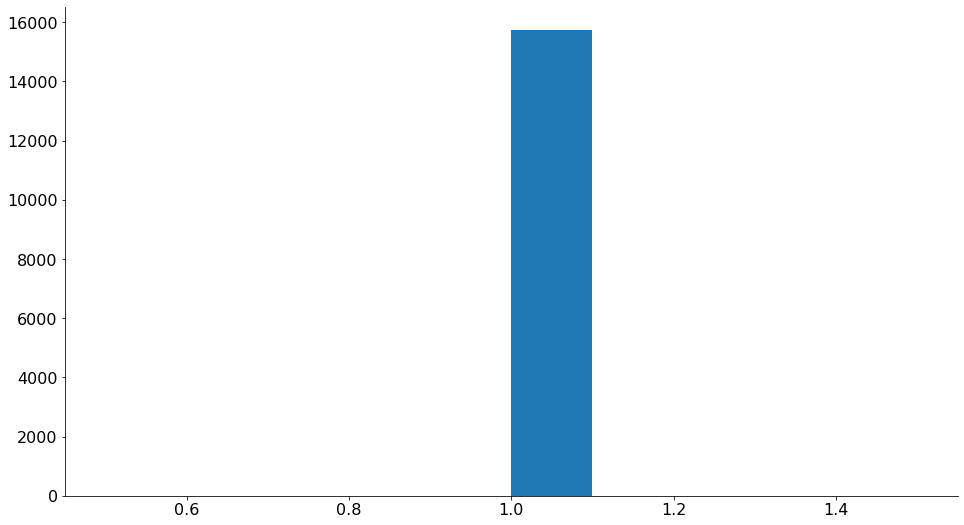

(0.3916702210491203, array([[    0,     1, 24676,  4376,    76,    23,     1,     0,     0],
       [13998, 53400, 11660, 15384,  5696,  3546,   780,   232,    36]]))


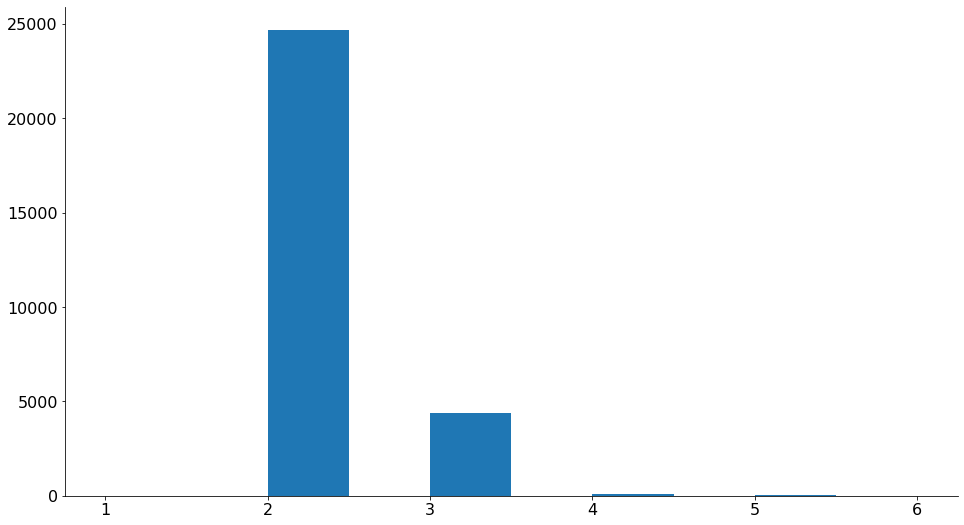

(0.049794501658989535, array([[    0,     0,  3448,     0,     0,     0,     0,     0,     0],
       [13998, 53401, 32888, 19760,  5772,  3569,   781,   232,    36]]))


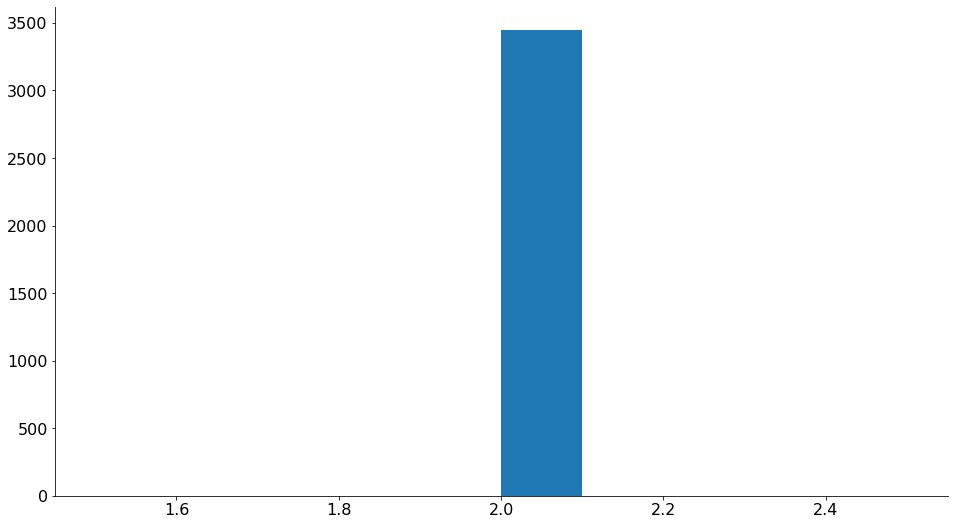

(0.18652307416796143, array([[    0,     0,     0,  7425,  1595,  1191,     8,     0,     0],
       [13998, 53401, 36336, 12335,  4177,  2378,   773,   232,    36]]))


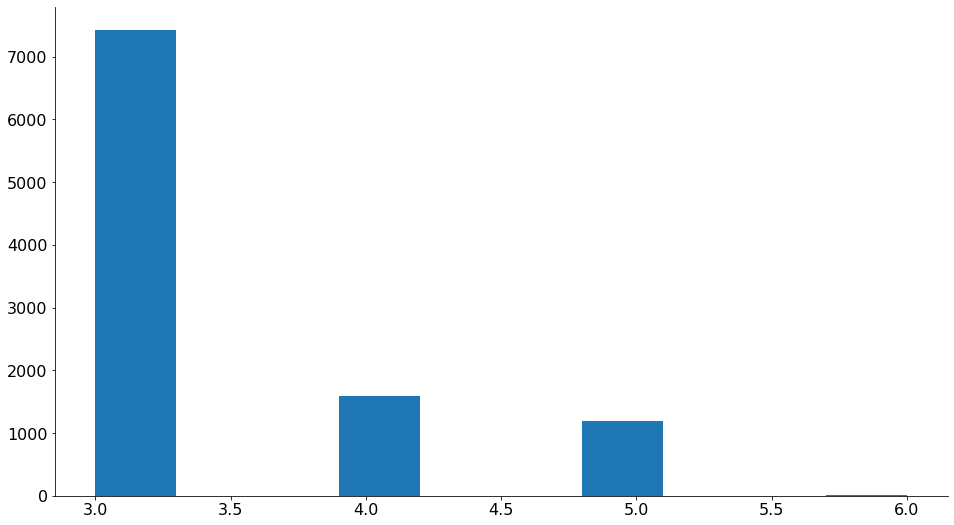

In [76]:
for i in range(6):
    print(space.mi("DBSCAN",set_val=i,prop="Rings",return_contingency=True))
    plt.hist(space.data.loc[space["DBSCAN"][i]]["Rings"])
    plt.show()

In [55]:
mi, cont = space.mi("DBSCAN",set_val=4,prop="Rings",return_contingency=True)

In [56]:
print(len(space["DBSCAN"][4]))

3448


<BarContainer object of 9 artists>

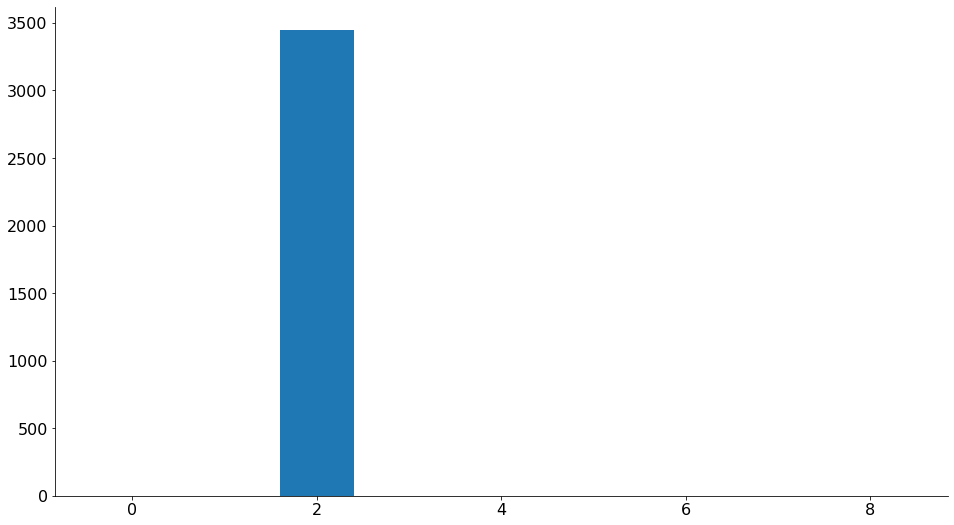

In [57]:
plt.bar(range(cont.shape[1]),cont[0,:])


<BarContainer object of 9 artists>

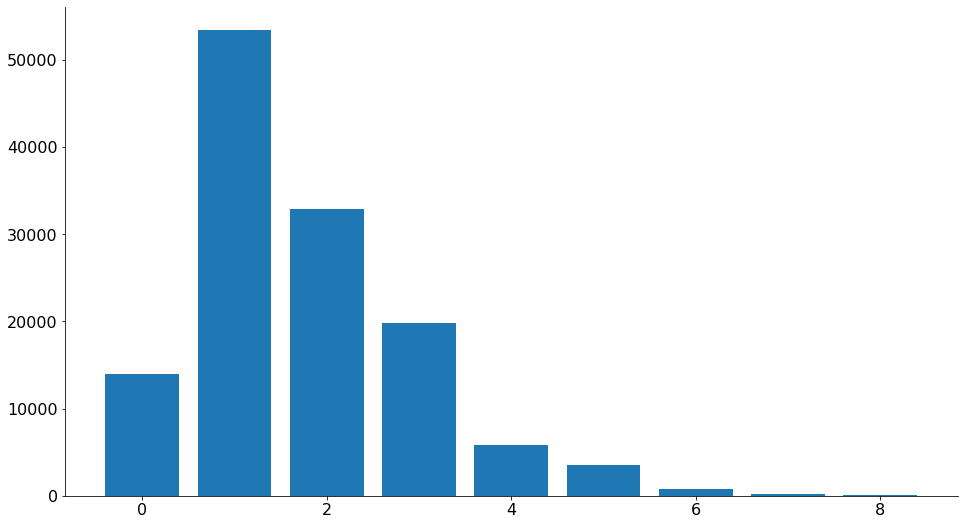

In [58]:
plt.bar(range(cont.shape[1]),cont[1,:])

In [59]:
cont

array([[    0,     0,  3448,     0,     0,     0,     0,     0,     0],
       [13998, 53401, 32888, 19760,  5772,  3569,   781,   232,    36]])

In [60]:
for i in range(7):

    print([np.sum(cont[:,:i],axis=1).reshape(-1,1), np.sum(cont[:,i:],axis=1).reshape(-1,1)])
    contingency = np.concatenate([np.sum(cont[:,:i],axis=1).reshape(-1,1), np.sum(cont[:,i:],axis=1).reshape(-1,1)],axis=1)
    total = 0
    N = np.sum(contingency)
    for x in range(contingency.shape[0]):
        for y in range(contingency.shape[1]):
            if contingency[x,y] == 0:
                total += 0
            else:
                total += (contingency[x,y]/N)*np.log2((N*contingency[x,y])/
                (np.sum(contingency[x,:])*np.sum(contingency[:,y])))

    print(total)

[array([[0],
       [0]]), array([[  3448],
       [130437]])]
0.0
[array([[    0],
       [13998]]), array([[  3448],
       [116439]])]
0.00415991324244901
[array([[    0],
       [67399]]), array([[ 3448],
       [63038]])]
0.026505615084029693
[array([[  3448],
       [100287]]), array([[    0],
       [30150]])]
0.009621475336389608
[array([[  3448],
       [120047]]), array([[    0],
       [10390]])]
0.0030423367665572774
[array([[  3448],
       [125819]]), array([[   0],
       [4618]])]
0.0013215587406865095
[array([[  3448],
       [129388]]), array([[   0],
       [1049]])]
0.00029609847186331227


In [ ]:
acyclic_space = MolSpace(fingerprints=fingerprints,
                      file="paper/Latent/Acyclic_Mols.csv",
                      mol_converters={"rd" : Chem.MolFromSmiles, "smiles" : str, "bonds" : bond_converter},
                      index_col="SMILES",
                      clusters={})

In [2]:
untrained_acyclic_labels = pd.read_csv("paper/Latent/Untrained_Acyclic_Clusters.csv")["DBSCAN"]
gap_acyclic_labels = pd.read_csv("paper/Latent/HOMO-LUMO Gap_Acyclic_Clusters.csv")["DBSCAN"]
dipole_acyclic_labels = pd.read_csv("paper/Latent/Dipole Moment_Acyclic_Clusters.csv")["DBSCAN"]
iso_acyclic_labels = pd.read_csv("paper/Latent/Isotropic Polarizability_Acyclic_Clusters.csv")["DBSCAN"]

acyclic_space.add_cluster(["untrained",untrained_acyclic_labels])
acyclic_space.add_cluster(["gap",gap_acyclic_labels])
acyclic_space.add_cluster(["dipole",dipole_acyclic_labels])
acyclic_space.add_cluster(["iso",iso_acyclic_labels])

NameError: name 'acyclic_space' is not defined

In [11]:
def num_branches(mol):
    return mol.count("(")

branch_fp = Fingerprint(property="Branches",
            noun="Molecules",
            verb="contain",
            label_type="multiclass",
            calculator=num_branches,
            mol_format="smiles")

def contains(substructure):
    match = Chem.MolFromSmarts(substructure)
    def sub_contains(mol):
        return int(mol.HasSubstructMatch(match))
    return sub_contains

contains_alkyne = Fingerprint(property=f"C#C",
                verb="contain",
                noun="Molecules",
                label_type="binary",
                calculator=contains('C#C'),
                mol_format="rd")

contains_ketone = Fingerprint(property=f"C=O",
                verb="contain",
                noun="Molecules",
                label_type="binary",
                calculator=contains('C=O'),
                mol_format="rd")

contains_cyano = Fingerprint(property=f"C#N",
                verb="contain",
                noun="Molecules",
                label_type="binary",
                calculator=contains('C#N'),
                mol_format="rd")

acyclic_space.add_fingerprint(branch_fp)
acyclic_space.add_fingerprint(contains_alkyne)
acyclic_space.add_fingerprint(contains_ketone)
acyclic_space.add_fingerprint(contains_cyano)

In [12]:
acyclic_space.data

Aromatic  Atoms  Rings  C  N  O  F  single bonds  double bonds  \
0             0      1      0  1  0  0  0             0             0   
1             0      1      0  0  1  0  0             0             0   
2             0      1      0  0  0  1  0             0             0   
3             0      2      0  1  0  0  0             0             0   
4             0      2      0  1  1  0  0             0             0   
...         ...    ...    ... .. .. .. ..           ...           ...   
13993         0      9      0  1  0  0  1             1             0   
13994         0      9      0  1  1  0  1             1             0   
13995         0      9      0  1  0  1  1             1             0   
13996         0      9      0  1  0  1  1             1             0   
13997         0      9      0  1  0  1  1             1             0   

       triple bonds  [CC]  [OH]  [NH2]  *=O  *O*  Branches  C#C  C=O  C#N  
0                 0     1     0      0    0    0         0    0    0    0  
1                 0     0     0      0    0    0         0    0    0    0  
2                 0     0     0      0    0    0         0    0    0    0  
3                 1     1     0      0    0    0         0    1    0    0  
4                 1     1     0      0    0    0         0    0    0    1  
...             ...   ...   ...    ...  ...  ...       ...  ...  ...  ...  
13993             0     1     0      0    0    0         2    0    0    0  
13994             0     1     0      0    0    0         2    0    0    0  
13995             0     1     0      0    0    1         2    0    0    0  
13996             0     1     0      0    0    1         2    0    0    0  
13997             0     1     0      0    0    1         2    0    0    0  

[13998 rows x 19 columns]

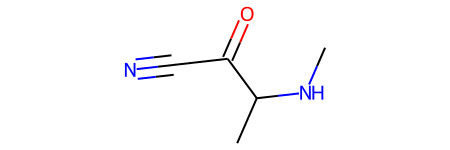

In [774]:
num  = 210
dat  = 9
m    = acyclic_space.mol_iters['rd'][acyclic_space["dipole"][dat]][num]
acyclic_space.mol_iters['rd'][acyclic_space["dipole"][dat]][num]

In [13]:
acyclic_space.gen_labels('untrained')

['Molecules contain Branches less than 3',
 'Molecules do not contain double bonds\nMolecules contain 0 Branches\nMutual Information 0.08454288080304359',
 'Molecules do not contain double bonds\nMolecules contain 0 Branches\nMolecules contain C#C\nMutual Information 0.04643213303811536',
 'Molecules do not contain F\nMolecules contain double bonds\nMutual Information 0.1746904256336494',
 'Molecules contain N\nMolecules do not contain triple bonds\nMolecules contain *=O\nMolecules contain 2 Branches\nMutual Information 0.023077017232834143',
 'Molecules contain double bonds\nMolecules contain triple bonds\nMolecules contain Branches greater than 1\nMutual Information 0.15120781088755067',
 'Molecules do not contain F\nMolecules contain Branches greater than 2\nMutual Information 0.18128376325869267',
 'Molecules contain Branches less than 3\nMutual Information 0.08450247873295941',
 'Molecules contain 2 Branches',
 'Molecules contain double bonds\nMolecules do not contain triple bonds

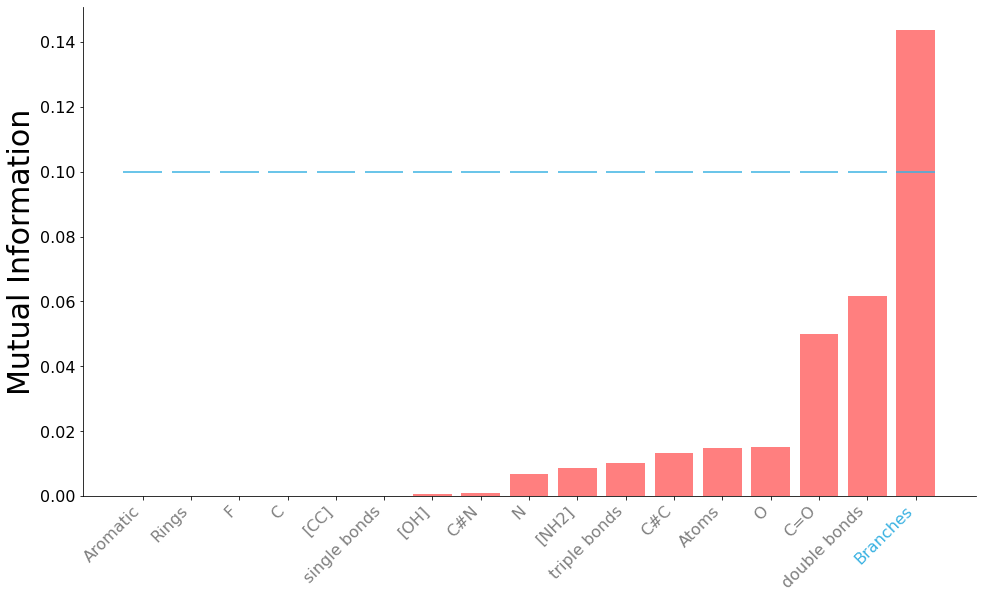

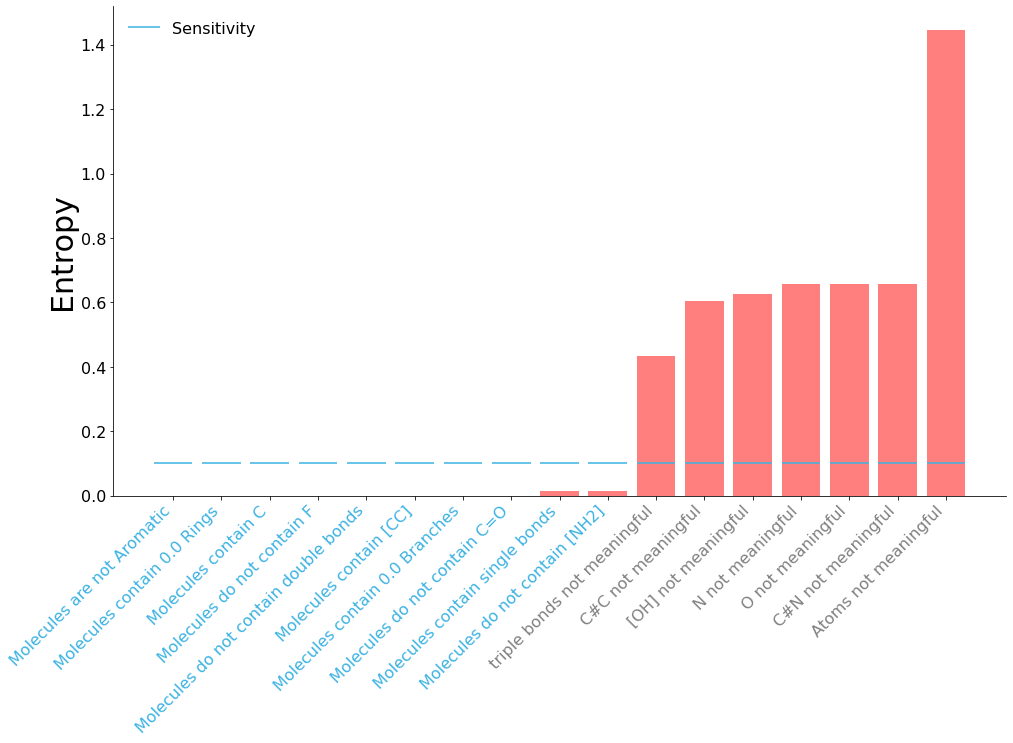

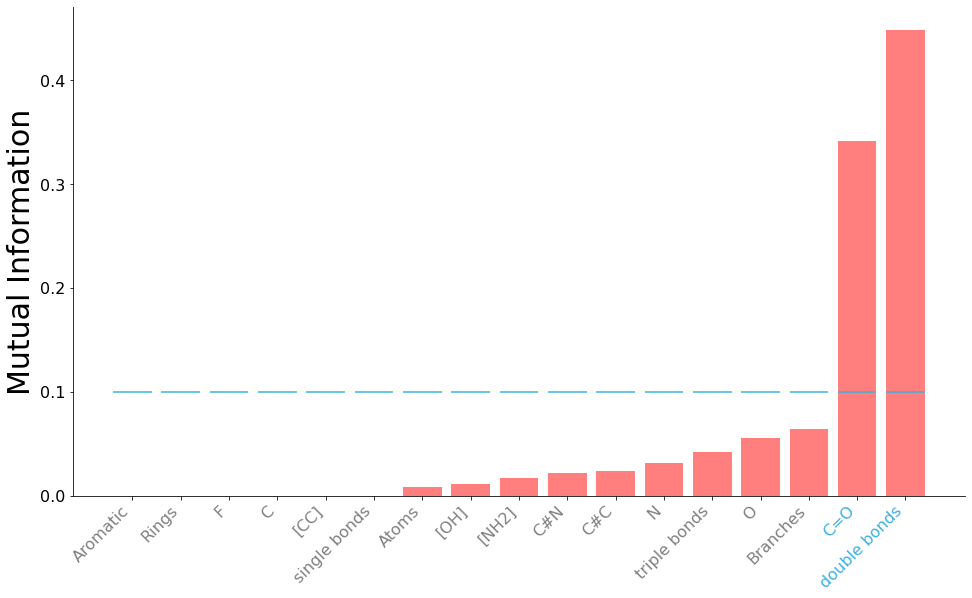

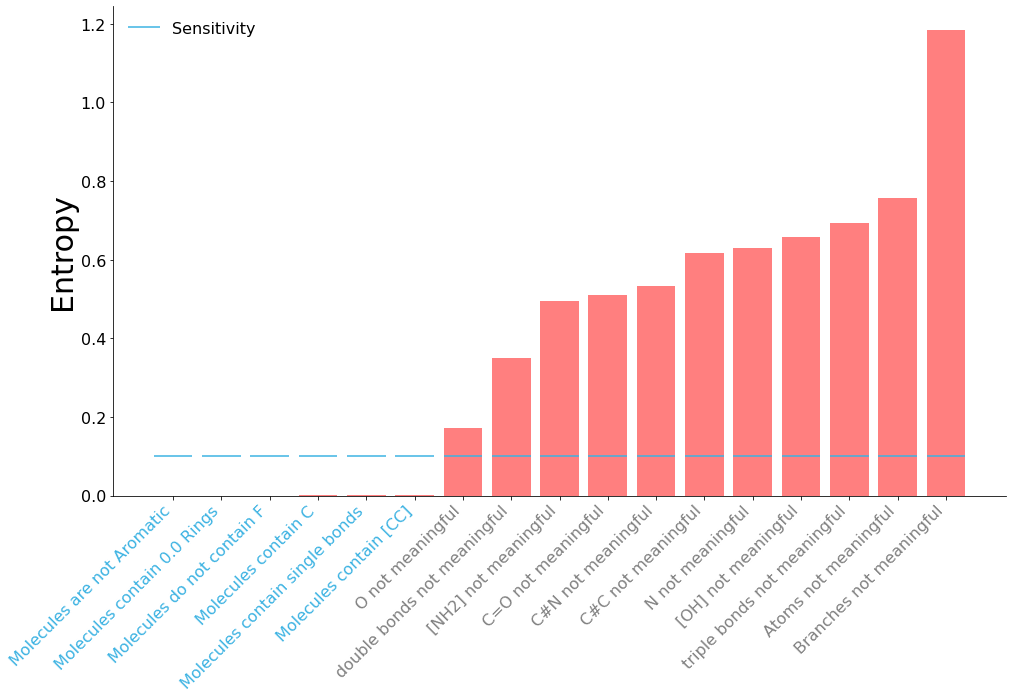

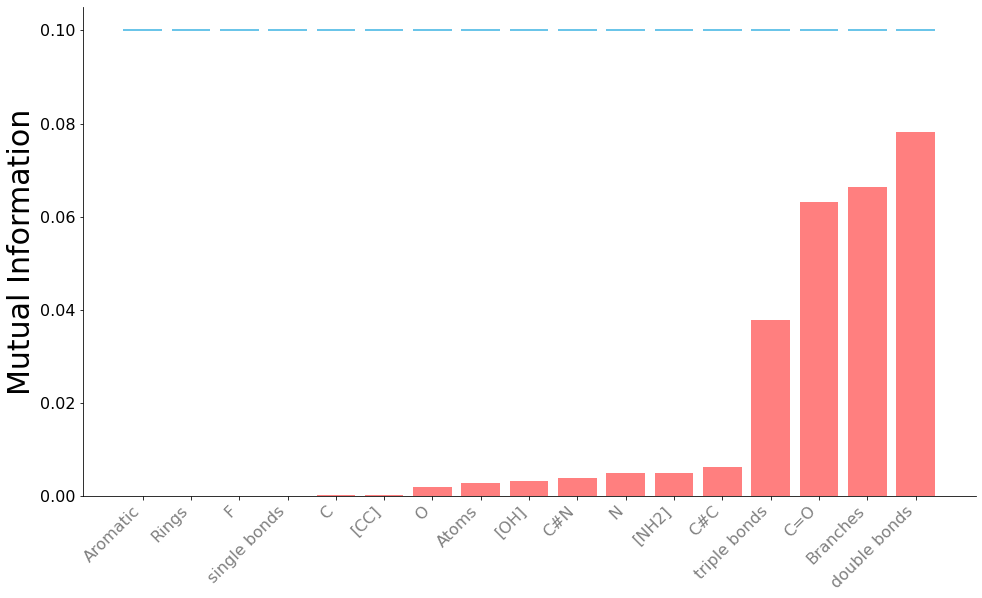

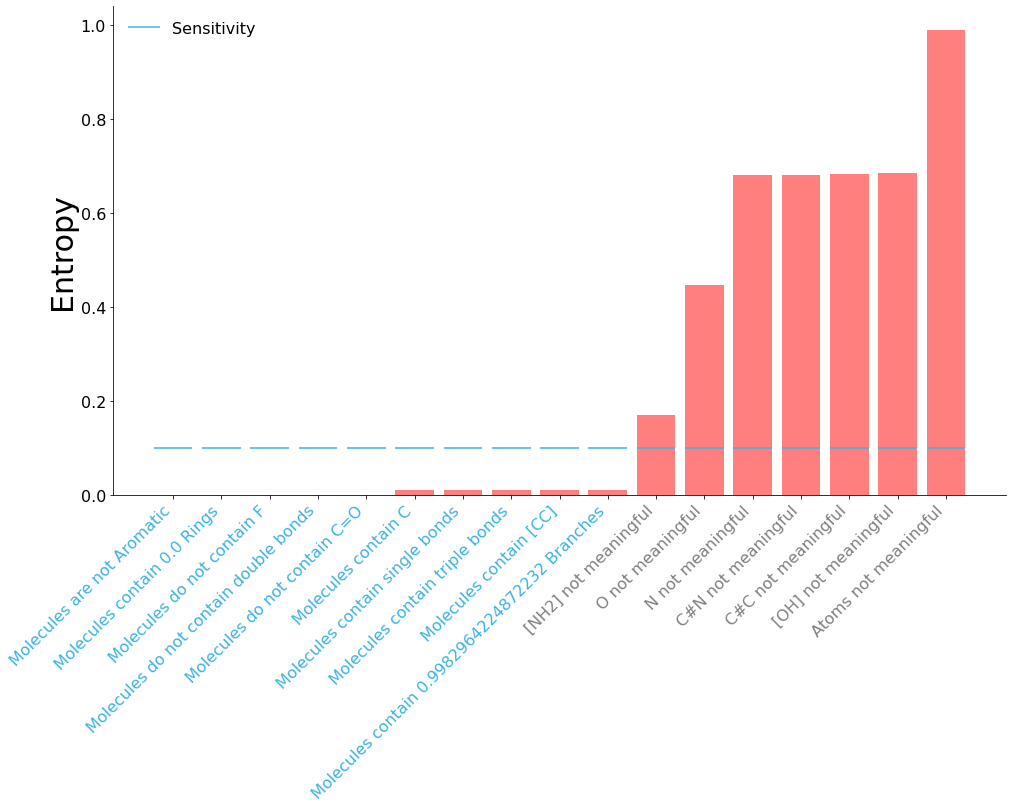

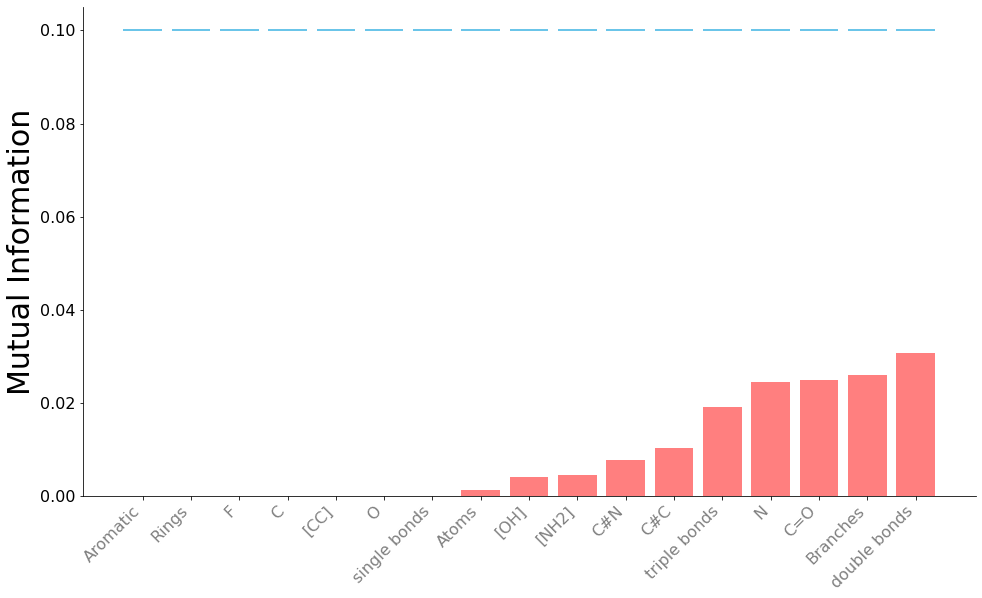

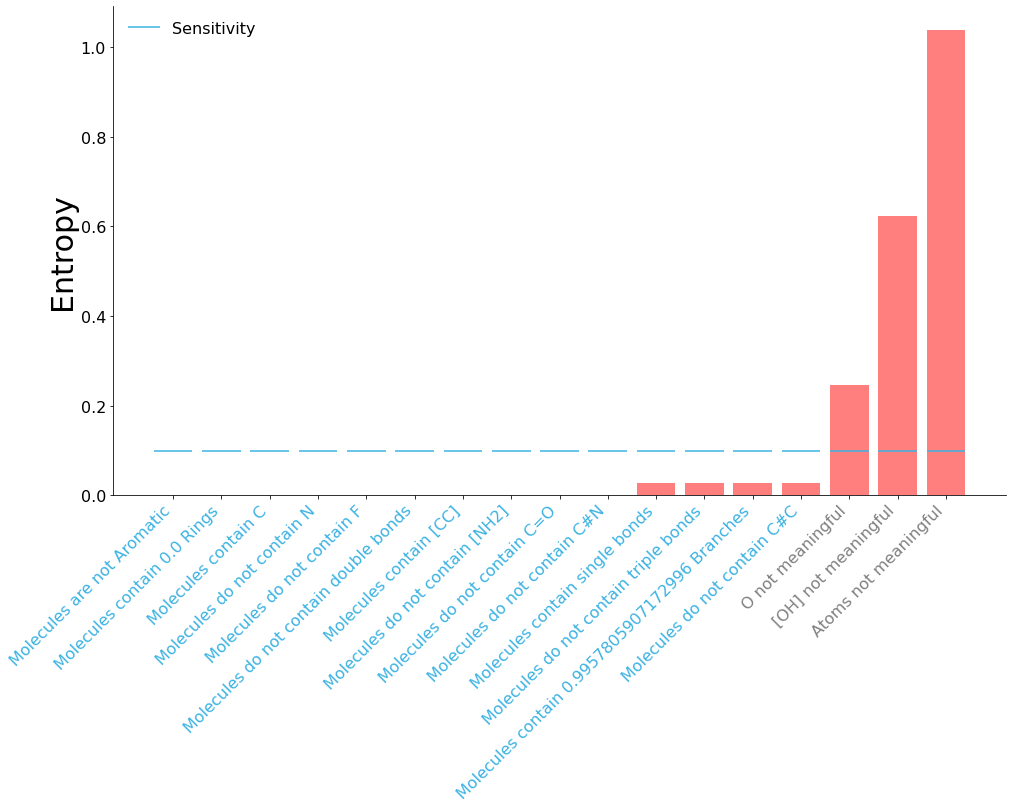

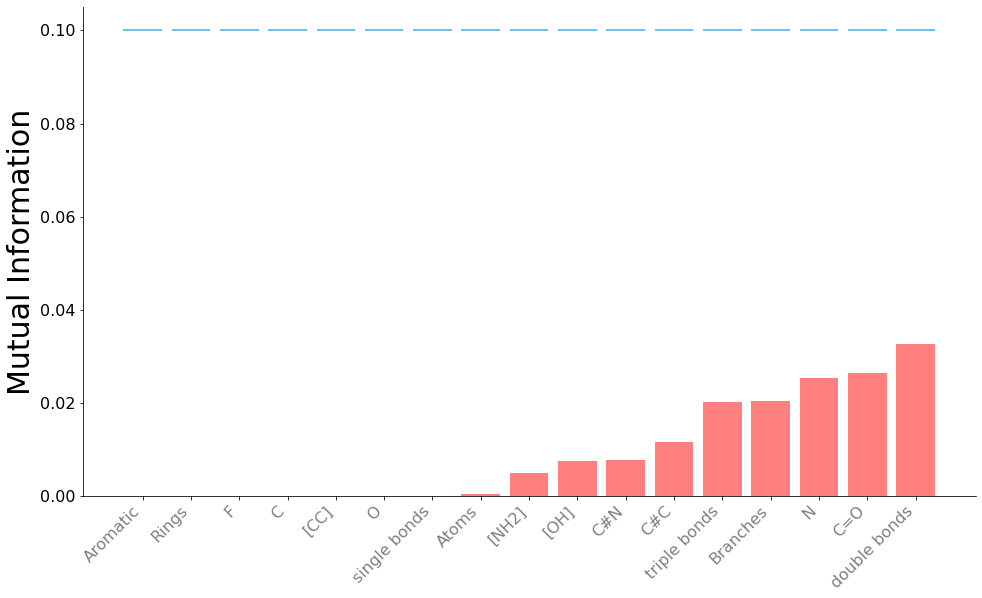

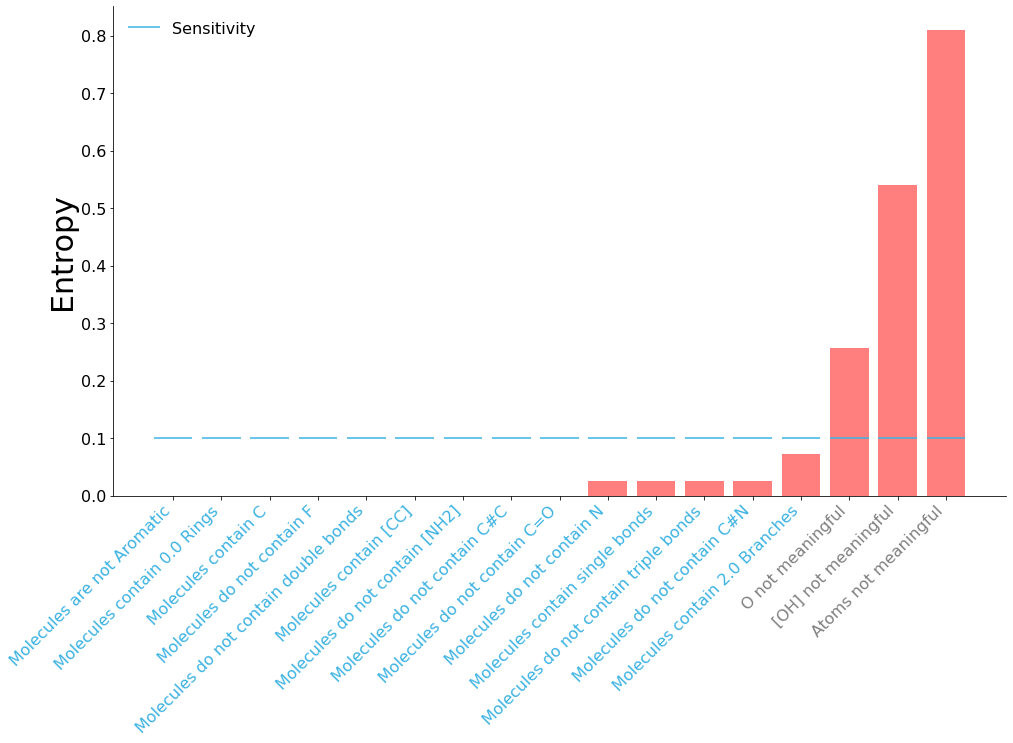

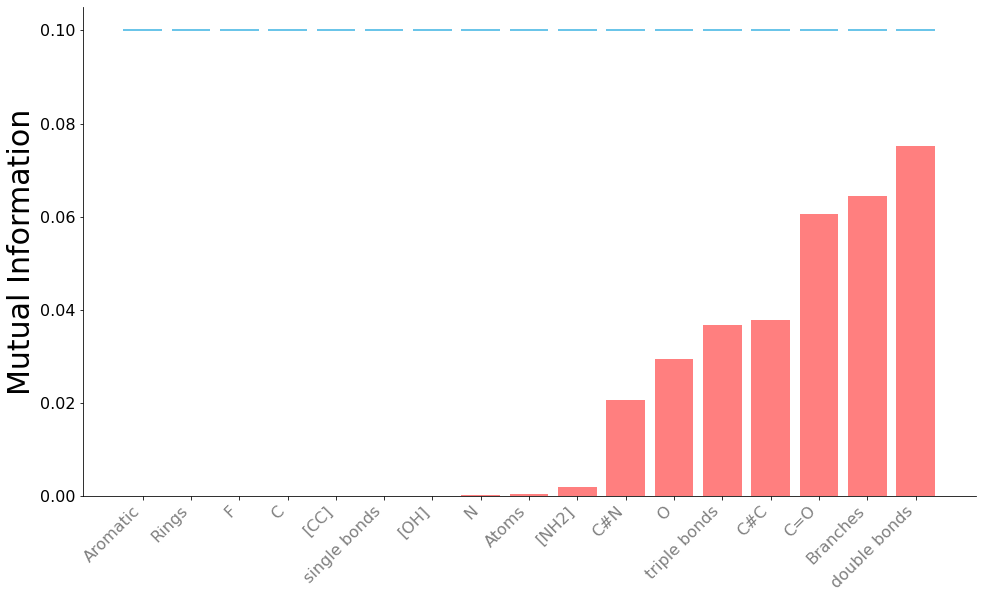

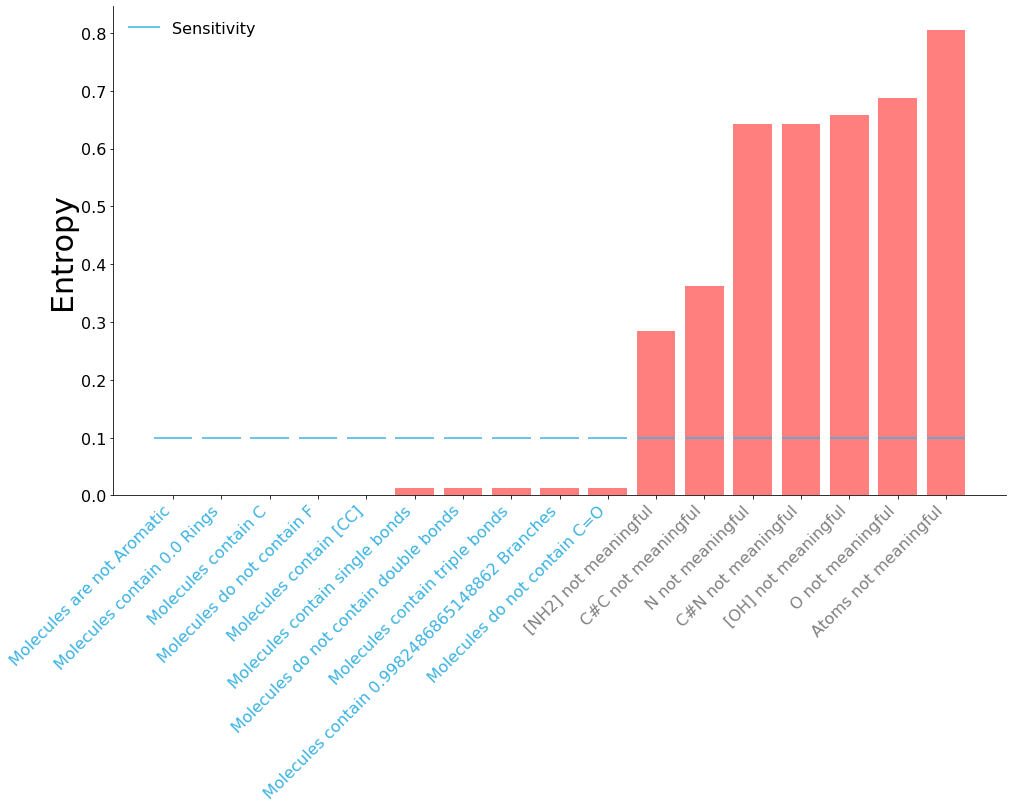

In [121]:
for i in range(6):
    acyclic_space.plot_mi("DBSCAN",set_val=i)
    plt.show()
    acyclic_space.plot_entropy("DBSCAN",set_val=i)
    plt.show()